In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from numpy import sqrt 

#Tien Xu Ly
from sklearn.preprocessing import MinMaxScaler

#Draw Flot
import matplotlib.pyplot as plt

#Cacuale error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#dtw Libaray
from dtw import dtw

#FFNN Libarary
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
# Load dữ liệu
dataCSV = pd.read_csv('D:/DATN/Dataset/GE.csv')
dataCSV

Date      Open      High       Low     Close  Adj Close  \
0      1962-01-02  0.751202  0.763722  0.743690  0.748698   0.001782   
1      1962-01-03  0.744942  0.744942  0.738682  0.741186   0.001764   
2      1962-01-04  0.741186  0.747446  0.726162  0.732422   0.001743   
3      1962-01-05  0.732422  0.733674  0.701122  0.713642   0.001698   
4      1962-01-08  0.713642  0.713642  0.691106  0.712390   0.001695   
...           ...       ...       ...       ...       ...        ...   
14658  2020-03-26  7.630000  8.300000  7.510000  8.120000   8.120000   
14659  2020-03-27  7.680000  7.870000  7.540000  7.620000   7.620000   
14660  2020-03-30  7.540000  7.940000  7.350000  7.890000   7.890000   
14661  2020-03-31  7.870000  8.180000  7.820000  7.940000   7.940000   
14662  2020-04-01  7.520000  7.550000  7.000000  7.040000   7.040000   

          Volume  
0        2156500  
1        1477600  
2        1837000  
3        2725600  
4        3095000  
...          ...  
14658  123180900  
14659   93299000  
14660   86850200  
14661  121149900  
14662   99330200  

[14663 rows x 7 columns]

In [3]:
data_GE=dataCSV[['Close']]

In [4]:
data_GE

Close
0      0.748698
1      0.741186
2      0.732422
3      0.713642
4      0.712390
...         ...
14658  8.120000
14659  7.620000
14660  7.890000
14661  7.940000
14662  7.040000

[14663 rows x 1 columns]

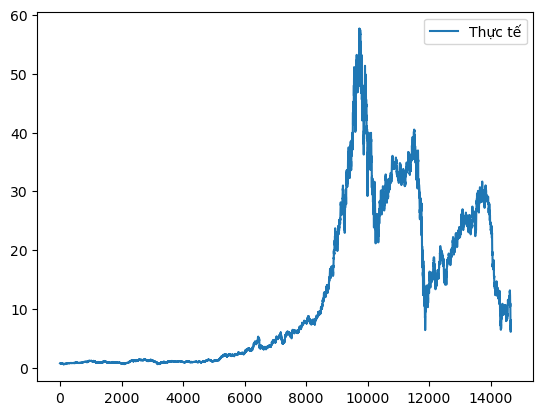

In [5]:
# Vẽ biểu đồ
plt.plot(data_GE, label='Thực tế')
plt.legend()
plt.show()

# Tiền xử lý GE

In [6]:
# Replace null values with 0
data_GE.fillna(0, inplace=True)

# Remove outliers by replacing values outside of 3 standard deviations with the mean
std = data_GE['Close'].std()
mean = data_GE['Close'].mean()
data_GE['Close'] = np.where(data_GE['Close'] > (mean + 10*std), mean, data_GE['Close'])
data_GE['Close'] = np.where(data_GE['Close'] < (mean - 10*std), mean, data_GE['Close'])

# # Scale data_AMZN to range [0, 1]
scaler = MinMaxScaler()
data_GE['Close'] = scaler.fit_transform(data_GE['Close'].values.reshape(-1, 1))

# Fill in missing values with the mean of the previous and next values
data_GE['Close'] = data_GE['Close'].interpolate(method='linear')

# Print the cleaned data_AMZN
print(data_GE)

          Close
0      0.003375
1      0.003243
2      0.003090
3      0.002761
4      0.002739
...         ...
14658  0.132387
14659  0.123636
14660  0.128361
14661  0.129237
14662  0.113485

[14663 rows x 1 columns]


In [7]:
data = data_GE

In [8]:
data

Close
0      0.003375
1      0.003243
2      0.003090
3      0.002761
4      0.002739
...         ...
14658  0.132387
14659  0.123636
14660  0.128361
14661  0.129237
14662  0.113485

[14663 rows x 1 columns]

In [9]:
# Chia dữ liệu thành train set và test set
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size, :]
test_data = data.iloc[train_size:, :]

In [10]:
#Xử lý dữ liệu thành dữ liệu đầu vào và đầu ra cho mô hình
def prepare_data(data, size_window,size_predict,stepWindow):
    X, y = [], []
    startWindow = 0
    for i in range(len(data) - size_window - 1):
        if (len(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0]) != size_predict):
            break
        X.append(data[startWindow:(startWindow + size_window), :])
        y.append(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0])
        print(data[startWindow:(startWindow + size_window), :])
        print("-----")
        print(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0])     
       
        startWindow += stepWindow
    return np.array(X), np.array(y)

size_window = 20
size_predict=1
stepWindow=1
X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
X_test, y_test = prepare_data(test_data.values, size_window, size_predict, stepWindow)

[[0.00337453]
 [0.00324305]
 [0.00308967]
 [0.00276098]
 [0.00273907]
 [0.0028048 ]
 [0.00287054]
 [0.00289245]
 [0.00271715]
 [0.00284863]
 [0.00295819]
 [0.00267333]
 [0.0028048 ]
 [0.00291437]
 [0.00295819]
 [0.00271715]
 [0.00295819]
 [0.00282672]
 [0.00278289]
 [0.0028048 ]]
-----
[0.00302393]
[[0.00324305]
 [0.00308967]
 [0.00276098]
 [0.00273907]
 [0.0028048 ]
 [0.00287054]
 [0.00289245]
 [0.00271715]
 [0.00284863]
 [0.00295819]
 [0.00267333]
 [0.0028048 ]
 [0.00291437]
 [0.00295819]
 [0.00271715]
 [0.00295819]
 [0.00282672]
 [0.00278289]
 [0.0028048 ]
 [0.00302393]]
-----
[0.00341835]
[[0.00308967]
 [0.00276098]
 [0.00273907]
 [0.0028048 ]
 [0.00287054]
 [0.00289245]
 [0.00271715]
 [0.00284863]
 [0.00295819]
 [0.00267333]
 [0.0028048 ]
 [0.00291437]
 [0.00295819]
 [0.00271715]
 [0.00295819]
 [0.00282672]
 [0.00278289]
 [0.0028048 ]
 [0.00302393]
 [0.00341835]]
-----
[0.0033307]
[[0.00276098]
 [0.00273907]
 [0.0028048 ]
 [0.00287054]
 [0.00289245]
 [0.00271715]
 [0.00284863]
 [0

[[0.00221317]
 [0.00205978]
 [0.00181874]
 [0.0012271 ]
 [0.00168726]
 [0.00179683]
 [0.00184065]
 [0.00131475]
 [0.00138049]
 [0.00151196]
 [0.00155579]
 [0.00166535]
 [0.00164344]
 [0.00102989]
 [0.00100798]
 [0.00094224]
 [0.00127093]
 [0.00109563]
 [0.00102989]
 [0.00078885]]
-----
[0.00043825]
[[0.00205978]
 [0.00181874]
 [0.0012271 ]
 [0.00168726]
 [0.00179683]
 [0.00184065]
 [0.00131475]
 [0.00138049]
 [0.00151196]
 [0.00155579]
 [0.00166535]
 [0.00164344]
 [0.00102989]
 [0.00100798]
 [0.00094224]
 [0.00127093]
 [0.00109563]
 [0.00102989]
 [0.00078885]
 [0.00043825]]
-----
[0.]
[[0.00181874]
 [0.0012271 ]
 [0.00168726]
 [0.00179683]
 [0.00184065]
 [0.00131475]
 [0.00138049]
 [0.00151196]
 [0.00155579]
 [0.00166535]
 [0.00164344]
 [0.00102989]
 [0.00100798]
 [0.00094224]
 [0.00127093]
 [0.00109563]
 [0.00102989]
 [0.00078885]
 [0.00043825]
 [0.        ]]
-----
[8.76495676e-05]
[[1.22710125e-03]
 [1.68726461e-03]
 [1.79682657e-03]
 [1.84065240e-03]
 [1.31475186e-03]
 [1.38048904e-

[[0.00214743]
 [0.00199404]
 [0.00186256]
 [0.00181874]
 [0.00205978]
 [0.00205978]
 [0.00199404]
 [0.00195021]
 [0.00173109]
 [0.00162153]
 [0.00151196]
 [0.00201595]
 [0.00184065]
 [0.00199404]
 [0.00203786]
 [0.00225699]
 [0.00214743]
 [0.00223508]
 [0.0024542 ]
 [0.00247611]]
-----
[0.00249803]
[[0.00199404]
 [0.00186256]
 [0.00181874]
 [0.00205978]
 [0.00205978]
 [0.00199404]
 [0.00195021]
 [0.00173109]
 [0.00162153]
 [0.00151196]
 [0.00201595]
 [0.00184065]
 [0.00199404]
 [0.00203786]
 [0.00225699]
 [0.00214743]
 [0.00223508]
 [0.0024542 ]
 [0.00247611]
 [0.00249803]]
-----
[0.00247611]
[[0.00186256]
 [0.00181874]
 [0.00205978]
 [0.00205978]
 [0.00199404]
 [0.00195021]
 [0.00173109]
 [0.00162153]
 [0.00151196]
 [0.00201595]
 [0.00184065]
 [0.00199404]
 [0.00203786]
 [0.00225699]
 [0.00214743]
 [0.00223508]
 [0.0024542 ]
 [0.00247611]
 [0.00249803]
 [0.00247611]]
-----
[0.00247611]
[[0.00181874]
 [0.00205978]
 [0.00205978]
 [0.00199404]
 [0.00195021]
 [0.00173109]
 [0.00162153]
 [

[[0.00374704]
 [0.00381278]
 [0.00372513]
 [0.00392234]
 [0.00394425]
 [0.00411955]
 [0.00409764]
 [0.00405382]
 [0.00405382]
 [0.00394425]
 [0.00398808]
 [0.00400999]
 [0.00403191]
 [0.00403191]
 [0.00409764]
 [0.00409764]
 [0.00411955]
 [0.00416338]
 [0.00416338]
 [0.00387852]]
-----
[0.00398808]
[[0.00381278]
 [0.00372513]
 [0.00392234]
 [0.00394425]
 [0.00411955]
 [0.00409764]
 [0.00405382]
 [0.00405382]
 [0.00394425]
 [0.00398808]
 [0.00400999]
 [0.00403191]
 [0.00403191]
 [0.00409764]
 [0.00409764]
 [0.00411955]
 [0.00416338]
 [0.00416338]
 [0.00387852]
 [0.00398808]]
-----
[0.00394425]
[[0.00372513]
 [0.00392234]
 [0.00394425]
 [0.00411955]
 [0.00409764]
 [0.00405382]
 [0.00405382]
 [0.00394425]
 [0.00398808]
 [0.00400999]
 [0.00403191]
 [0.00403191]
 [0.00409764]
 [0.00409764]
 [0.00411955]
 [0.00416338]
 [0.00416338]
 [0.00387852]
 [0.00398808]
 [0.00394425]]
-----
[0.00387852]
[[0.00392234]
 [0.00394425]
 [0.00411955]
 [0.00409764]
 [0.00405382]
 [0.00405382]
 [0.00394425]
 [

[[0.00462354]
 [0.00460163]
 [0.00460163]
 [0.00455781]
 [0.00449207]
 [0.00455781]
 [0.00449207]
 [0.00453589]
 [0.00447016]
 [0.00425103]
 [0.00447016]
 [0.00444824]
 [0.00455781]
 [0.00464546]
 [0.00442633]
 [0.00460163]
 [0.00457972]
 [0.00451398]
 [0.00455781]
 [0.00466737]]
-----
[0.00484267]
[[0.00460163]
 [0.00460163]
 [0.00455781]
 [0.00449207]
 [0.00455781]
 [0.00449207]
 [0.00453589]
 [0.00447016]
 [0.00425103]
 [0.00447016]
 [0.00444824]
 [0.00455781]
 [0.00464546]
 [0.00442633]
 [0.00460163]
 [0.00457972]
 [0.00451398]
 [0.00455781]
 [0.00466737]
 [0.00484267]]
-----
[0.00484267]
[[0.00460163]
 [0.00455781]
 [0.00449207]
 [0.00455781]
 [0.00449207]
 [0.00453589]
 [0.00447016]
 [0.00425103]
 [0.00447016]
 [0.00444824]
 [0.00455781]
 [0.00464546]
 [0.00442633]
 [0.00460163]
 [0.00457972]
 [0.00451398]
 [0.00455781]
 [0.00466737]
 [0.00484267]
 [0.00484267]]
-----
[0.00462354]
[[0.00455781]
 [0.00449207]
 [0.00455781]
 [0.00449207]
 [0.00453589]
 [0.00447016]
 [0.00425103]
 [

-----
[0.00403191]
[[0.00431677]
 [0.00442633]
 [0.00442633]
 [0.00436059]
 [0.00482076]
 [0.00512753]
 [0.00484267]
 [0.00495223]
 [0.00473311]
 [0.00464546]
 [0.00451398]
 [0.00431677]
 [0.00451398]
 [0.00460163]
 [0.00453589]
 [0.00433868]
 [0.00440442]
 [0.00427294]
 [0.00396617]
 [0.00403191]]
-----
[0.00420721]
[[0.00442633]
 [0.00442633]
 [0.00436059]
 [0.00482076]
 [0.00512753]
 [0.00484267]
 [0.00495223]
 [0.00473311]
 [0.00464546]
 [0.00451398]
 [0.00431677]
 [0.00451398]
 [0.00460163]
 [0.00453589]
 [0.00433868]
 [0.00440442]
 [0.00427294]
 [0.00396617]
 [0.00403191]
 [0.00420721]]
-----
[0.00396617]
[[0.00442633]
 [0.00436059]
 [0.00482076]
 [0.00512753]
 [0.00484267]
 [0.00495223]
 [0.00473311]
 [0.00464546]
 [0.00451398]
 [0.00431677]
 [0.00451398]
 [0.00460163]
 [0.00453589]
 [0.00433868]
 [0.00440442]
 [0.00427294]
 [0.00396617]
 [0.00403191]
 [0.00420721]
 [0.00396617]]
-----
[0.00348409]
[[0.00436059]
 [0.00482076]
 [0.00512753]
 [0.00484267]
 [0.00495223]
 [0.0047331

[[0.00486458]
 [0.00473311]
 [0.00475502]
 [0.00484267]
 [0.00479884]
 [0.00475502]
 [0.00440442]
 [0.00460163]
 [0.00488649]
 [0.00490841]
 [0.00497414]
 [0.00468928]
 [0.00475502]
 [0.00477693]
 [0.00477693]
 [0.00468928]
 [0.00449207]
 [0.00449207]
 [0.00447016]
 [0.00449207]]
-----
[0.00436059]
[[0.00473311]
 [0.00475502]
 [0.00484267]
 [0.00479884]
 [0.00475502]
 [0.00440442]
 [0.00460163]
 [0.00488649]
 [0.00490841]
 [0.00497414]
 [0.00468928]
 [0.00475502]
 [0.00477693]
 [0.00477693]
 [0.00468928]
 [0.00449207]
 [0.00449207]
 [0.00447016]
 [0.00449207]
 [0.00436059]]
-----
[0.00431677]
[[0.00475502]
 [0.00484267]
 [0.00479884]
 [0.00475502]
 [0.00440442]
 [0.00460163]
 [0.00488649]
 [0.00490841]
 [0.00497414]
 [0.00468928]
 [0.00475502]
 [0.00477693]
 [0.00477693]
 [0.00468928]
 [0.00449207]
 [0.00449207]
 [0.00447016]
 [0.00449207]
 [0.00436059]
 [0.00431677]]
-----
[0.00414147]
[[0.00484267]
 [0.00479884]
 [0.00475502]
 [0.00440442]
 [0.00460163]
 [0.00488649]
 [0.00490841]
 [

[0.00826102]
[[0.00819528]
 [0.0082172 ]
 [0.00826102]
 [0.00828294]
 [0.00828294]
 [0.00819528]
 [0.00830485]
 [0.00848015]
 [0.00832676]
 [0.00780086]
 [0.00755982]
 [0.00766938]
 [0.00771321]
 [0.00780086]
 [0.00777895]
 [0.00784468]
 [0.00797616]
 [0.00797616]
 [0.0082172 ]
 [0.00826102]]
-----
[0.00817337]
[[0.0082172 ]
 [0.00826102]
 [0.00828294]
 [0.00828294]
 [0.00819528]
 [0.00830485]
 [0.00848015]
 [0.00832676]
 [0.00780086]
 [0.00755982]
 [0.00766938]
 [0.00771321]
 [0.00780086]
 [0.00777895]
 [0.00784468]
 [0.00797616]
 [0.00797616]
 [0.0082172 ]
 [0.00826102]
 [0.00817337]]
-----
[0.00823911]
[[0.00826102]
 [0.00828294]
 [0.00828294]
 [0.00819528]
 [0.00830485]
 [0.00848015]
 [0.00832676]
 [0.00780086]
 [0.00755982]
 [0.00766938]
 [0.00771321]
 [0.00780086]
 [0.00777895]
 [0.00784468]
 [0.00797616]
 [0.00797616]
 [0.0082172 ]
 [0.00826102]
 [0.00817337]
 [0.00823911]]
-----
[0.00828294]
[[0.00828294]
 [0.00828294]
 [0.00819528]
 [0.00830485]
 [0.00848015]
 [0.00832676]
 [0

[[0.00788851]
 [0.00799807]
 [0.00766938]
 [0.0073407 ]
 [0.00709966]
 [0.00720922]
 [0.00703392]
 [0.00714348]
 [0.00731878]
 [0.00745026]
 [0.00727496]
 [0.00742835]
 [0.00738452]
 [0.00738452]
 [0.0069901 ]
 [0.00672715]
 [0.00631081]
 [0.00670523]
 [0.00707775]
 [0.00723113]]
-----
[0.00749408]
[[0.00799807]
 [0.00766938]
 [0.0073407 ]
 [0.00709966]
 [0.00720922]
 [0.00703392]
 [0.00714348]
 [0.00731878]
 [0.00745026]
 [0.00727496]
 [0.00742835]
 [0.00738452]
 [0.00738452]
 [0.0069901 ]
 [0.00672715]
 [0.00631081]
 [0.00670523]
 [0.00707775]
 [0.00723113]
 [0.00749408]]
-----
[0.00755982]
[[0.00766938]
 [0.0073407 ]
 [0.00709966]
 [0.00720922]
 [0.00703392]
 [0.00714348]
 [0.00731878]
 [0.00745026]
 [0.00727496]
 [0.00742835]
 [0.00738452]
 [0.00738452]
 [0.0069901 ]
 [0.00672715]
 [0.00631081]
 [0.00670523]
 [0.00707775]
 [0.00723113]
 [0.00749408]
 [0.00755982]]
-----
[0.00755982]
[[0.0073407 ]
 [0.00709966]
 [0.00720922]
 [0.00703392]
 [0.00714348]
 [0.00731878]
 [0.00745026]
 [

[[0.01091244]
 [0.01117539]
 [0.01124113]
 [0.0111973 ]
 [0.01117539]
 [0.01108774]
 [0.01069331]
 [0.01080288]
 [0.0106714 ]
 [0.01069331]
 [0.01062757]
 [0.01064949]
 [0.01086861]
 [0.01071522]
 [0.01086861]
 [0.01080288]
 [0.01060566]
 [0.01034271]
 [0.01038654]
 [0.00986064]]
-----
[0.01021124]
[[0.01117539]
 [0.01124113]
 [0.0111973 ]
 [0.01117539]
 [0.01108774]
 [0.01069331]
 [0.01080288]
 [0.0106714 ]
 [0.01069331]
 [0.01062757]
 [0.01064949]
 [0.01086861]
 [0.01071522]
 [0.01086861]
 [0.01080288]
 [0.01060566]
 [0.01034271]
 [0.01038654]
 [0.00986064]
 [0.01021124]]
-----
[0.01021124]
[[0.01124113]
 [0.0111973 ]
 [0.01117539]
 [0.01108774]
 [0.01069331]
 [0.01080288]
 [0.0106714 ]
 [0.01069331]
 [0.01062757]
 [0.01064949]
 [0.01086861]
 [0.01071522]
 [0.01086861]
 [0.01080288]
 [0.01060566]
 [0.01034271]
 [0.01038654]
 [0.00986064]
 [0.01021124]
 [0.01021124]]
-----
[0.01023315]
[[0.0111973 ]
 [0.01117539]
 [0.01108774]
 [0.01069331]
 [0.01080288]
 [0.0106714 ]
 [0.01069331]
 [

[[0.00929091]
 [0.00942239]
 [0.0096196 ]
 [0.00968534]
 [0.00959769]
 [0.00983872]
 [0.01036462]
 [0.01095626]
 [0.01086861]
 [0.01071522]
 [0.01075905]
 [0.01093435]
 [0.0106714 ]
 [0.01040845]
 [0.01005785]
 [0.01007976]
 [0.00981681]
 [0.00986064]
 [0.00968534]
 [0.00920326]]
-----
[0.00937856]
[[0.00942239]
 [0.0096196 ]
 [0.00968534]
 [0.00959769]
 [0.00983872]
 [0.01036462]
 [0.01095626]
 [0.01086861]
 [0.01071522]
 [0.01075905]
 [0.01093435]
 [0.0106714 ]
 [0.01040845]
 [0.01005785]
 [0.01007976]
 [0.00981681]
 [0.00986064]
 [0.00968534]
 [0.00920326]
 [0.00937856]]
-----
[0.00937856]
[[0.0096196 ]
 [0.00968534]
 [0.00959769]
 [0.00983872]
 [0.01036462]
 [0.01095626]
 [0.01086861]
 [0.01071522]
 [0.01075905]
 [0.01093435]
 [0.0106714 ]
 [0.01040845]
 [0.01005785]
 [0.01007976]
 [0.00981681]
 [0.00986064]
 [0.00968534]
 [0.00920326]
 [0.00937856]
 [0.00937856]]
-----
[0.00900605]
[[0.00968534]
 [0.00959769]
 [0.00983872]
 [0.01036462]
 [0.01095626]
 [0.01086861]
 [0.01071522]
 [

[[0.00694627]
 [0.00707775]
 [0.00692436]
 [0.0069901 ]
 [0.00718731]
 [0.00729687]
 [0.00725305]
 [0.00727496]
 [0.00705583]
 [0.00709966]
 [0.00718731]
 [0.00749408]
 [0.00731878]
 [0.00738452]
 [0.00727496]
 [0.0073407 ]
 [0.00736261]
 [0.00720922]
 [0.00736261]
 [0.00727496]]
-----
[0.00731878]
[[0.00707775]
 [0.00692436]
 [0.0069901 ]
 [0.00718731]
 [0.00729687]
 [0.00725305]
 [0.00727496]
 [0.00705583]
 [0.00709966]
 [0.00718731]
 [0.00749408]
 [0.00731878]
 [0.00738452]
 [0.00727496]
 [0.0073407 ]
 [0.00736261]
 [0.00720922]
 [0.00736261]
 [0.00727496]
 [0.00731878]]
-----
[0.0076913]
[[0.00692436]
 [0.0069901 ]
 [0.00718731]
 [0.00729687]
 [0.00725305]
 [0.00727496]
 [0.00705583]
 [0.00709966]
 [0.00718731]
 [0.00749408]
 [0.00731878]
 [0.00738452]
 [0.00727496]
 [0.0073407 ]
 [0.00736261]
 [0.00720922]
 [0.00736261]
 [0.00727496]
 [0.00731878]
 [0.0076913 ]]
-----
[0.00745026]
[[0.0069901 ]
 [0.00718731]
 [0.00729687]
 [0.00725305]
 [0.00727496]
 [0.00705583]
 [0.00709966]
 [0

[0.00539048]
[[0.00567534]
 [0.00569726]
 [0.00591638]
 [0.00600403]
 [0.00602594]
 [0.00593829]
 [0.00589447]
 [0.00552196]
 [0.00576299]
 [0.00552196]
 [0.00554387]
 [0.00554387]
 [0.00525901]
 [0.00514944]
 [0.00484267]
 [0.00479884]
 [0.00525901]
 [0.00534666]
 [0.00532474]
 [0.00539048]]
-----
[0.00543431]
[[0.00569726]
 [0.00591638]
 [0.00600403]
 [0.00602594]
 [0.00593829]
 [0.00589447]
 [0.00552196]
 [0.00576299]
 [0.00552196]
 [0.00554387]
 [0.00554387]
 [0.00525901]
 [0.00514944]
 [0.00484267]
 [0.00479884]
 [0.00525901]
 [0.00534666]
 [0.00532474]
 [0.00539048]
 [0.00543431]]
-----
[0.00565343]
[[0.00591638]
 [0.00600403]
 [0.00602594]
 [0.00593829]
 [0.00589447]
 [0.00552196]
 [0.00576299]
 [0.00552196]
 [0.00554387]
 [0.00554387]
 [0.00525901]
 [0.00514944]
 [0.00484267]
 [0.00479884]
 [0.00525901]
 [0.00534666]
 [0.00532474]
 [0.00539048]
 [0.00543431]
 [0.00565343]]
-----
[0.00569726]
[[0.00600403]
 [0.00602594]
 [0.00593829]
 [0.00589447]
 [0.00552196]
 [0.00576299]
 [0

[[0.00539048]
 [0.00530283]
 [0.00565343]
 [0.00591638]
 [0.00613551]
 [0.00731878]
 [0.00729687]
 [0.00810763]
 [0.00771321]
 [0.00819528]
 [0.00863354]
 [0.00837058]
 [0.00823911]
 [0.00832676]
 [0.00861162]
 [0.00887457]
 [0.00920326]
 [0.009269  ]
 [0.00920326]
 [0.00902796]]
-----
[0.00902796]
[[0.00530283]
 [0.00565343]
 [0.00591638]
 [0.00613551]
 [0.00731878]
 [0.00729687]
 [0.00810763]
 [0.00771321]
 [0.00819528]
 [0.00863354]
 [0.00837058]
 [0.00823911]
 [0.00832676]
 [0.00861162]
 [0.00887457]
 [0.00920326]
 [0.009269  ]
 [0.00920326]
 [0.00902796]
 [0.00902796]]
-----
[0.00898414]
[[0.00565343]
 [0.00591638]
 [0.00613551]
 [0.00731878]
 [0.00729687]
 [0.00810763]
 [0.00771321]
 [0.00819528]
 [0.00863354]
 [0.00837058]
 [0.00823911]
 [0.00832676]
 [0.00861162]
 [0.00887457]
 [0.00920326]
 [0.009269  ]
 [0.00920326]
 [0.00902796]
 [0.00902796]
 [0.00898414]]
-----
[0.00902796]
[[0.00591638]
 [0.00613551]
 [0.00731878]
 [0.00729687]
 [0.00810763]
 [0.00771321]
 [0.00819528]
 [

[[0.00793233]
 [0.00753791]
 [0.00762556]
 [0.00830485]
 [0.00806381]
 [0.00793233]
 [0.00850206]
 [0.00863354]
 [0.00850206]
 [0.00861162]
 [0.00885266]
 [0.00902796]
 [0.00852397]
 [0.00848015]
 [0.00843632]
 [0.00845823]
 [0.00850206]
 [0.00837058]
 [0.0078666 ]
 [0.00753791]]
-----
[0.00725305]
[[0.00753791]
 [0.00762556]
 [0.00830485]
 [0.00806381]
 [0.00793233]
 [0.00850206]
 [0.00863354]
 [0.00850206]
 [0.00861162]
 [0.00885266]
 [0.00902796]
 [0.00852397]
 [0.00848015]
 [0.00843632]
 [0.00845823]
 [0.00850206]
 [0.00837058]
 [0.0078666 ]
 [0.00753791]
 [0.00725305]]
-----
[0.00749408]
[[0.00762556]
 [0.00830485]
 [0.00806381]
 [0.00793233]
 [0.00850206]
 [0.00863354]
 [0.00850206]
 [0.00861162]
 [0.00885266]
 [0.00902796]
 [0.00852397]
 [0.00848015]
 [0.00843632]
 [0.00845823]
 [0.00850206]
 [0.00837058]
 [0.0078666 ]
 [0.00753791]
 [0.00725305]
 [0.00749408]]
-----
[0.00736261]
[[0.00830485]
 [0.00806381]
 [0.00793233]
 [0.00850206]
 [0.00863354]
 [0.00850206]
 [0.00861162]
 [

[[0.00532474]
 [0.00532474]
 [0.00523709]
 [0.00528092]
 [0.00495223]
 [0.00493032]
 [0.00488649]
 [0.00495223]
 [0.00497414]
 [0.00506179]
 [0.00488649]
 [0.00484267]
 [0.00503988]
 [0.00490841]
 [0.00442633]
 [0.00455781]
 [0.00464546]
 [0.00462354]
 [0.00455781]
 [0.00466737]]
-----
[0.00477693]
[[0.00532474]
 [0.00523709]
 [0.00528092]
 [0.00495223]
 [0.00493032]
 [0.00488649]
 [0.00495223]
 [0.00497414]
 [0.00506179]
 [0.00488649]
 [0.00484267]
 [0.00503988]
 [0.00490841]
 [0.00442633]
 [0.00455781]
 [0.00464546]
 [0.00462354]
 [0.00455781]
 [0.00466737]
 [0.00477693]]
-----
[0.00468928]
[[0.00523709]
 [0.00528092]
 [0.00495223]
 [0.00493032]
 [0.00488649]
 [0.00495223]
 [0.00497414]
 [0.00506179]
 [0.00488649]
 [0.00484267]
 [0.00503988]
 [0.00490841]
 [0.00442633]
 [0.00455781]
 [0.00464546]
 [0.00462354]
 [0.00455781]
 [0.00466737]
 [0.00477693]
 [0.00468928]]
-----
[0.00479884]
[[0.00528092]
 [0.00495223]
 [0.00493032]
 [0.00488649]
 [0.00495223]
 [0.00497414]
 [0.00506179]
 [

[[0.00609168]
 [0.00598212]
 [0.00631081]
 [0.00615742]
 [0.00609168]
 [0.00622316]
 [0.00617933]
 [0.00611359]
 [0.00589447]
 [0.00585064]
 [0.00585064]
 [0.00600403]
 [0.00617933]
 [0.00604786]
 [0.00613551]
 [0.00620124]
 [0.00604786]
 [0.00596021]
 [0.00565343]
 [0.00552196]]
-----
[0.00517136]
[[0.00598212]
 [0.00631081]
 [0.00615742]
 [0.00609168]
 [0.00622316]
 [0.00617933]
 [0.00611359]
 [0.00589447]
 [0.00585064]
 [0.00585064]
 [0.00600403]
 [0.00617933]
 [0.00604786]
 [0.00613551]
 [0.00620124]
 [0.00604786]
 [0.00596021]
 [0.00565343]
 [0.00552196]
 [0.00517136]]
-----
[0.00541239]
[[0.00631081]
 [0.00615742]
 [0.00609168]
 [0.00622316]
 [0.00617933]
 [0.00611359]
 [0.00589447]
 [0.00585064]
 [0.00585064]
 [0.00600403]
 [0.00617933]
 [0.00604786]
 [0.00613551]
 [0.00620124]
 [0.00604786]
 [0.00596021]
 [0.00565343]
 [0.00552196]
 [0.00517136]
 [0.00541239]]
-----
[0.00519327]
[[0.00615742]
 [0.00609168]
 [0.00622316]
 [0.00617933]
 [0.00611359]
 [0.00589447]
 [0.00585064]
 [

[[0.00506179]
 [0.00503988]
 [0.00517136]
 [0.00525901]
 [0.00517136]
 [0.00514944]
 [0.00519327]
 [0.00506179]
 [0.00490841]
 [0.00475502]
 [0.00486458]
 [0.00508371]
 [0.00486458]
 [0.00482076]
 [0.00497414]
 [0.00517136]
 [0.00519327]
 [0.00534666]
 [0.00536857]
 [0.00523709]]
-----
[0.00541239]
[[0.00503988]
 [0.00517136]
 [0.00525901]
 [0.00517136]
 [0.00514944]
 [0.00519327]
 [0.00506179]
 [0.00490841]
 [0.00475502]
 [0.00486458]
 [0.00508371]
 [0.00486458]
 [0.00482076]
 [0.00497414]
 [0.00517136]
 [0.00519327]
 [0.00534666]
 [0.00536857]
 [0.00523709]
 [0.00541239]]
-----
[0.00532474]
[[0.00517136]
 [0.00525901]
 [0.00517136]
 [0.00514944]
 [0.00519327]
 [0.00506179]
 [0.00490841]
 [0.00475502]
 [0.00486458]
 [0.00508371]
 [0.00486458]
 [0.00482076]
 [0.00497414]
 [0.00517136]
 [0.00519327]
 [0.00534666]
 [0.00536857]
 [0.00523709]
 [0.00541239]
 [0.00532474]]
-----
[0.00534666]
[[0.00525901]
 [0.00517136]
 [0.00514944]
 [0.00519327]
 [0.00506179]
 [0.00490841]
 [0.00475502]
 [

[[0.01064949]
 [0.01086861]
 [0.01104391]
 [0.01078096]
 [0.01082479]
 [0.01078096]
 [0.01113156]
 [0.01156981]
 [0.01161364]
 [0.01152599]
 [0.01161364]
 [0.01165746]
 [0.01183276]
 [0.01174511]
 [0.01165746]
 [0.01126304]
 [0.01086861]
 [0.01078096]
 [0.01003594]
 [0.01003594]]
-----
[0.01047419]
[[0.01086861]
 [0.01104391]
 [0.01078096]
 [0.01082479]
 [0.01078096]
 [0.01113156]
 [0.01156981]
 [0.01161364]
 [0.01152599]
 [0.01161364]
 [0.01165746]
 [0.01183276]
 [0.01174511]
 [0.01165746]
 [0.01126304]
 [0.01086861]
 [0.01078096]
 [0.01003594]
 [0.01003594]
 [0.01047419]]
-----
[0.01021124]
[[0.01104391]
 [0.01078096]
 [0.01082479]
 [0.01078096]
 [0.01113156]
 [0.01156981]
 [0.01161364]
 [0.01152599]
 [0.01161364]
 [0.01165746]
 [0.01183276]
 [0.01174511]
 [0.01165746]
 [0.01126304]
 [0.01086861]
 [0.01078096]
 [0.01003594]
 [0.01003594]
 [0.01047419]
 [0.01021124]]
-----
[0.00937856]
[[0.01078096]
 [0.01082479]
 [0.01078096]
 [0.01113156]
 [0.01156981]
 [0.01161364]
 [0.01152599]
 [

[[0.01468139]
 [0.01476904]
 [0.01437462]
 [0.01459374]
 [0.01446227]
 [0.01446227]
 [0.01454992]
 [0.01402402]
 [0.01362959]
 [0.01327899]
 [0.01354194]
 [0.01345429]
 [0.01345429]
 [0.01362959]
 [0.01345429]
 [0.01341047]
 [0.01358577]
 [0.01411167]
 [0.01411167]
 [0.01380489]]
-----
[0.01367341]
[[0.01476904]
 [0.01437462]
 [0.01459374]
 [0.01446227]
 [0.01446227]
 [0.01454992]
 [0.01402402]
 [0.01362959]
 [0.01327899]
 [0.01354194]
 [0.01345429]
 [0.01345429]
 [0.01362959]
 [0.01345429]
 [0.01341047]
 [0.01358577]
 [0.01411167]
 [0.01411167]
 [0.01380489]
 [0.01367341]]
-----
[0.01358577]
[[0.01437462]
 [0.01459374]
 [0.01446227]
 [0.01446227]
 [0.01454992]
 [0.01402402]
 [0.01362959]
 [0.01327899]
 [0.01354194]
 [0.01345429]
 [0.01345429]
 [0.01362959]
 [0.01345429]
 [0.01341047]
 [0.01358577]
 [0.01411167]
 [0.01411167]
 [0.01380489]
 [0.01367341]
 [0.01358577]]
-----
[0.01345429]
[[0.01459374]
 [0.01446227]
 [0.01446227]
 [0.01454992]
 [0.01402402]
 [0.01362959]
 [0.01327899]
 [

[[0.01297221]
 [0.01323517]
 [0.01362959]
 [0.01402402]
 [0.01437462]
 [0.01433079]
 [0.01441844]
 [0.01454992]
 [0.01459374]
 [0.01463757]
 [0.01376107]
 [0.01384872]
 [0.01367341]
 [0.01371724]
 [0.01341047]
 [0.01301604]
 [0.01319134]
 [0.01319134]
 [0.01358577]
 [0.01367341]]
-----
[0.01358577]
[[0.01323517]
 [0.01362959]
 [0.01402402]
 [0.01437462]
 [0.01433079]
 [0.01441844]
 [0.01454992]
 [0.01459374]
 [0.01463757]
 [0.01376107]
 [0.01384872]
 [0.01367341]
 [0.01371724]
 [0.01341047]
 [0.01301604]
 [0.01319134]
 [0.01319134]
 [0.01358577]
 [0.01367341]
 [0.01358577]]
-----
[0.01380489]
[[0.01362959]
 [0.01402402]
 [0.01437462]
 [0.01433079]
 [0.01441844]
 [0.01454992]
 [0.01459374]
 [0.01463757]
 [0.01376107]
 [0.01384872]
 [0.01367341]
 [0.01371724]
 [0.01341047]
 [0.01301604]
 [0.01319134]
 [0.01319134]
 [0.01358577]
 [0.01367341]
 [0.01358577]
 [0.01380489]]
-----
[0.01367341]
[[0.01402402]
 [0.01437462]
 [0.01433079]
 [0.01441844]
 [0.01454992]
 [0.01459374]
 [0.01463757]
 [

[[0.01288456]
 [0.01279692]
 [0.01279692]
 [0.01266544]
 [0.01266544]
 [0.01262161]
 [0.01275309]
 [0.01262161]
 [0.01231484]
 [0.01130686]
 [0.01161364]
 [0.01148216]
 [0.01104391]
 [0.01126304]
 [0.01121921]
 [0.01135069]
 [0.01200806]
 [0.01187659]
 [0.01192041]
 [0.01196424]]
-----
[0.01165746]
[[0.01279692]
 [0.01279692]
 [0.01266544]
 [0.01266544]
 [0.01262161]
 [0.01275309]
 [0.01262161]
 [0.01231484]
 [0.01130686]
 [0.01161364]
 [0.01148216]
 [0.01104391]
 [0.01126304]
 [0.01121921]
 [0.01135069]
 [0.01200806]
 [0.01187659]
 [0.01192041]
 [0.01196424]
 [0.01165746]]
-----
[0.01121921]
[[0.01279692]
 [0.01266544]
 [0.01266544]
 [0.01262161]
 [0.01275309]
 [0.01262161]
 [0.01231484]
 [0.01130686]
 [0.01161364]
 [0.01148216]
 [0.01104391]
 [0.01126304]
 [0.01121921]
 [0.01135069]
 [0.01200806]
 [0.01187659]
 [0.01192041]
 [0.01196424]
 [0.01165746]
 [0.01121921]]
-----
[0.01069331]
[[0.01266544]
 [0.01266544]
 [0.01262161]
 [0.01275309]
 [0.01262161]
 [0.01231484]
 [0.01130686]
 [

[[0.00964151]
 [0.00915944]
 [0.00929091]
 [0.00986064]
 [0.00986064]
 [0.01007976]
 [0.01060566]
 [0.01056184]
 [0.01051801]
 [0.01069331]
 [0.01051801]
 [0.01012359]
 [0.01007976]
 [0.00994829]
 [0.00990446]
 [0.00990446]
 [0.00964151]
 [0.00977299]
 [0.01016741]
 [0.01007976]]
-----
[0.00955386]
[[0.00915944]
 [0.00929091]
 [0.00986064]
 [0.00986064]
 [0.01007976]
 [0.01060566]
 [0.01056184]
 [0.01051801]
 [0.01069331]
 [0.01051801]
 [0.01012359]
 [0.01007976]
 [0.00994829]
 [0.00990446]
 [0.00990446]
 [0.00964151]
 [0.00977299]
 [0.01016741]
 [0.01007976]
 [0.00955386]]
-----
[0.00889648]
[[0.00929091]
 [0.00986064]
 [0.00986064]
 [0.01007976]
 [0.01060566]
 [0.01056184]
 [0.01051801]
 [0.01069331]
 [0.01051801]
 [0.01012359]
 [0.01007976]
 [0.00994829]
 [0.00990446]
 [0.00990446]
 [0.00964151]
 [0.00977299]
 [0.01016741]
 [0.01007976]
 [0.00955386]
 [0.00889648]]
-----
[0.00880883]
[[0.00986064]
 [0.00986064]
 [0.01007976]
 [0.01060566]
 [0.01056184]
 [0.01051801]
 [0.01069331]
 [

[[0.00232273]
 [0.0021036 ]
 [0.00170918]
 [0.00179683]
 [0.00113945]
 [0.00170918]
 [0.0019283 ]
 [0.00197213]
 [0.0015777 ]
 [0.0014024 ]
 [0.00149005]
 [0.00170918]
 [0.00162153]
 [0.00149005]
 [0.00197213]
 [0.0021036 ]
 [0.00170918]
 [0.00170918]
 [0.00205978]
 [0.0021036 ]]
-----
[0.00223508]
[[0.0021036 ]
 [0.00170918]
 [0.00179683]
 [0.00113945]
 [0.00170918]
 [0.0019283 ]
 [0.00197213]
 [0.0015777 ]
 [0.0014024 ]
 [0.00149005]
 [0.00170918]
 [0.00162153]
 [0.00149005]
 [0.00197213]
 [0.0021036 ]
 [0.00170918]
 [0.00170918]
 [0.00205978]
 [0.0021036 ]
 [0.00223508]]
-----
[0.00284863]
[[0.00170918]
 [0.00179683]
 [0.00113945]
 [0.00170918]
 [0.0019283 ]
 [0.00197213]
 [0.0015777 ]
 [0.0014024 ]
 [0.00149005]
 [0.00170918]
 [0.00162153]
 [0.00149005]
 [0.00197213]
 [0.0021036 ]
 [0.00170918]
 [0.00170918]
 [0.00205978]
 [0.0021036 ]
 [0.00223508]
 [0.00284863]]
-----
[0.00302393]
[[0.00179683]
 [0.00113945]
 [0.00170918]
 [0.0019283 ]
 [0.00197213]
 [0.0015777 ]
 [0.0014024 ]
 [

[[0.00609168]
 [0.00582873]
 [0.00609168]
 [0.00666141]
 [0.00701201]
 [0.00727496]
 [0.00740643]
 [0.00740643]
 [0.00709966]
 [0.00639846]
 [0.00587256]
 [0.00617933]
 [0.00626698]
 [0.00604786]
 [0.00600403]
 [0.00596021]
 [0.00596021]
 [0.00600403]
 [0.00639846]
 [0.00674906]]
-----
[0.00718731]
[[0.00582873]
 [0.00609168]
 [0.00666141]
 [0.00701201]
 [0.00727496]
 [0.00740643]
 [0.00740643]
 [0.00709966]
 [0.00639846]
 [0.00587256]
 [0.00617933]
 [0.00626698]
 [0.00604786]
 [0.00600403]
 [0.00596021]
 [0.00596021]
 [0.00600403]
 [0.00639846]
 [0.00674906]
 [0.00718731]]
-----
[0.00705583]
[[0.00609168]
 [0.00666141]
 [0.00701201]
 [0.00727496]
 [0.00740643]
 [0.00740643]
 [0.00709966]
 [0.00639846]
 [0.00587256]
 [0.00617933]
 [0.00626698]
 [0.00604786]
 [0.00600403]
 [0.00596021]
 [0.00596021]
 [0.00600403]
 [0.00639846]
 [0.00674906]
 [0.00718731]
 [0.00705583]]
-----
[0.00635463]
[[0.00666141]
 [0.00701201]
 [0.00727496]
 [0.00740643]
 [0.00740643]
 [0.00709966]
 [0.00639846]
 [

[[0.00543431]
 [0.00587256]
 [0.00552196]
 [0.00560961]
 [0.00582873]
 [0.00591638]
 [0.00622316]
 [0.00578491]
 [0.00569726]
 [0.00517136]
 [0.00578491]
 [0.00626698]
 [0.00617933]
 [0.00635463]
 [0.00679288]
 [0.00709966]
 [0.00692436]
 [0.00718731]
 [0.00692436]
 [0.00701201]]
-----
[0.00696818]
[[0.00587256]
 [0.00552196]
 [0.00560961]
 [0.00582873]
 [0.00591638]
 [0.00622316]
 [0.00578491]
 [0.00569726]
 [0.00517136]
 [0.00578491]
 [0.00626698]
 [0.00617933]
 [0.00635463]
 [0.00679288]
 [0.00709966]
 [0.00692436]
 [0.00718731]
 [0.00692436]
 [0.00701201]
 [0.00696818]]
-----
[0.00692436]
[[0.00552196]
 [0.00560961]
 [0.00582873]
 [0.00591638]
 [0.00622316]
 [0.00578491]
 [0.00569726]
 [0.00517136]
 [0.00578491]
 [0.00626698]
 [0.00617933]
 [0.00635463]
 [0.00679288]
 [0.00709966]
 [0.00692436]
 [0.00718731]
 [0.00692436]
 [0.00701201]
 [0.00696818]
 [0.00692436]]
-----
[0.00723113]
[[0.00560961]
 [0.00582873]
 [0.00591638]
 [0.00622316]
 [0.00578491]
 [0.00569726]
 [0.00517136]
 [

[[0.00631081]
 [0.00622316]
 [0.00617933]
 [0.00657376]
 [0.00631081]
 [0.00644228]
 [0.00644228]
 [0.00661758]
 [0.00701201]
 [0.00745026]
 [0.00766938]
 [0.00780086]
 [0.00801998]
 [0.00845823]
 [0.00819528]
 [0.00841441]
 [0.00841441]
 [0.00832676]
 [0.00885266]
 [0.00920326]]
-----
[0.00902796]
[[0.00622316]
 [0.00617933]
 [0.00657376]
 [0.00631081]
 [0.00644228]
 [0.00644228]
 [0.00661758]
 [0.00701201]
 [0.00745026]
 [0.00766938]
 [0.00780086]
 [0.00801998]
 [0.00845823]
 [0.00819528]
 [0.00841441]
 [0.00841441]
 [0.00832676]
 [0.00885266]
 [0.00920326]
 [0.00902796]]
-----
[0.00894031]
[[0.00617933]
 [0.00657376]
 [0.00631081]
 [0.00644228]
 [0.00644228]
 [0.00661758]
 [0.00701201]
 [0.00745026]
 [0.00766938]
 [0.00780086]
 [0.00801998]
 [0.00845823]
 [0.00819528]
 [0.00841441]
 [0.00841441]
 [0.00832676]
 [0.00885266]
 [0.00920326]
 [0.00902796]
 [0.00894031]]
-----
[0.00946621]
[[0.00657376]
 [0.00631081]
 [0.00644228]
 [0.00644228]
 [0.00661758]
 [0.00701201]
 [0.00745026]
 [

[[0.01056184]
 [0.01051801]
 [0.01025506]
 [0.01007976]
 [0.00964151]
 [0.00977299]
 [0.00951004]
 [0.00937856]
 [0.00915944]
 [0.00937856]
 [0.00946621]
 [0.00955386]
 [0.00946621]
 [0.00959769]
 [0.00955386]
 [0.00959769]
 [0.00986064]
 [0.00968534]
 [0.00981681]
 [0.00986064]]
-----
[0.01003594]
[[0.01051801]
 [0.01025506]
 [0.01007976]
 [0.00964151]
 [0.00977299]
 [0.00951004]
 [0.00937856]
 [0.00915944]
 [0.00937856]
 [0.00946621]
 [0.00955386]
 [0.00946621]
 [0.00959769]
 [0.00955386]
 [0.00959769]
 [0.00986064]
 [0.00968534]
 [0.00981681]
 [0.00986064]
 [0.01003594]]
-----
[0.00994829]
[[0.01025506]
 [0.01007976]
 [0.00964151]
 [0.00977299]
 [0.00951004]
 [0.00937856]
 [0.00915944]
 [0.00937856]
 [0.00946621]
 [0.00955386]
 [0.00946621]
 [0.00959769]
 [0.00955386]
 [0.00959769]
 [0.00986064]
 [0.00968534]
 [0.00981681]
 [0.00986064]
 [0.01003594]
 [0.00994829]]
-----
[0.00968534]
[[0.01007976]
 [0.00964151]
 [0.00977299]
 [0.00951004]
 [0.00937856]
 [0.00915944]
 [0.00937856]
 [

[[0.00819528]
 [0.00806381]
 [0.00815146]
 [0.00815146]
 [0.00810763]
 [0.00810763]
 [0.00823911]
 [0.00832676]
 [0.00837058]
 [0.00845823]
 [0.00832676]
 [0.00823911]
 [0.00828294]
 [0.00815146]
 [0.00801998]
 [0.00823911]
 [0.00810763]
 [0.00810763]
 [0.00815146]
 [0.00815146]]
-----
[0.00823911]
[[0.00806381]
 [0.00815146]
 [0.00815146]
 [0.00810763]
 [0.00810763]
 [0.00823911]
 [0.00832676]
 [0.00837058]
 [0.00845823]
 [0.00832676]
 [0.00823911]
 [0.00828294]
 [0.00815146]
 [0.00801998]
 [0.00823911]
 [0.00810763]
 [0.00810763]
 [0.00815146]
 [0.00815146]
 [0.00823911]]
-----
[0.00872119]
[[0.00815146]
 [0.00815146]
 [0.00810763]
 [0.00810763]
 [0.00823911]
 [0.00832676]
 [0.00837058]
 [0.00845823]
 [0.00832676]
 [0.00823911]
 [0.00828294]
 [0.00815146]
 [0.00801998]
 [0.00823911]
 [0.00810763]
 [0.00810763]
 [0.00815146]
 [0.00815146]
 [0.00823911]
 [0.00872119]]
-----
[0.00894031]
[[0.00815146]
 [0.00810763]
 [0.00810763]
 [0.00823911]
 [0.00832676]
 [0.00837058]
 [0.00845823]
 [

[[0.01012359]
 [0.01016741]
 [0.01003594]
 [0.01003594]
 [0.00994829]
 [0.00977299]
 [0.00990446]
 [0.00999211]
 [0.00999211]
 [0.00999211]
 [0.01003594]
 [0.01007976]
 [0.00994829]
 [0.00986064]
 [0.00986064]
 [0.00986064]
 [0.00981681]
 [0.00951004]
 [0.00951004]
 [0.00955386]]
-----
[0.00959769]
[[0.01016741]
 [0.01003594]
 [0.01003594]
 [0.00994829]
 [0.00977299]
 [0.00990446]
 [0.00999211]
 [0.00999211]
 [0.00999211]
 [0.01003594]
 [0.01007976]
 [0.00994829]
 [0.00986064]
 [0.00986064]
 [0.00986064]
 [0.00981681]
 [0.00951004]
 [0.00951004]
 [0.00955386]
 [0.00959769]]
-----
[0.00955386]
[[0.01003594]
 [0.01003594]
 [0.00994829]
 [0.00977299]
 [0.00990446]
 [0.00999211]
 [0.00999211]
 [0.00999211]
 [0.01003594]
 [0.01007976]
 [0.00994829]
 [0.00986064]
 [0.00986064]
 [0.00986064]
 [0.00981681]
 [0.00951004]
 [0.00951004]
 [0.00955386]
 [0.00959769]
 [0.00955386]]
-----
[0.00977299]
[[0.01003594]
 [0.00994829]
 [0.00977299]
 [0.00990446]
 [0.00999211]
 [0.00999211]
 [0.00999211]
 [

[[0.00766938]
 [0.00758173]
 [0.00727496]
 [0.00723113]
 [0.00718731]
 [0.00723113]
 [0.00718731]
 [0.00731878]
 [0.00736261]
 [0.00736261]
 [0.00718731]
 [0.00705583]
 [0.00701201]
 [0.00731878]
 [0.00762556]
 [0.00780086]
 [0.00775703]
 [0.00766938]
 [0.00771321]
 [0.00775703]]
-----
[0.00736261]
[[0.00758173]
 [0.00727496]
 [0.00723113]
 [0.00718731]
 [0.00723113]
 [0.00718731]
 [0.00731878]
 [0.00736261]
 [0.00736261]
 [0.00718731]
 [0.00705583]
 [0.00701201]
 [0.00731878]
 [0.00762556]
 [0.00780086]
 [0.00775703]
 [0.00766938]
 [0.00771321]
 [0.00775703]
 [0.00736261]]
-----
[0.00731878]
[[0.00727496]
 [0.00723113]
 [0.00718731]
 [0.00723113]
 [0.00718731]
 [0.00731878]
 [0.00736261]
 [0.00736261]
 [0.00718731]
 [0.00705583]
 [0.00701201]
 [0.00731878]
 [0.00762556]
 [0.00780086]
 [0.00775703]
 [0.00766938]
 [0.00771321]
 [0.00775703]
 [0.00736261]
 [0.00731878]]
-----
[0.00731878]
[[0.00723113]
 [0.00718731]
 [0.00723113]
 [0.00718731]
 [0.00731878]
 [0.00736261]
 [0.00736261]
 [

[[0.00666141]
 [0.00674906]
 [0.00666141]
 [0.00666141]
 [0.00679288]
 [0.00701201]
 [0.00674906]
 [0.00670523]
 [0.00657376]
 [0.00666141]
 [0.00683671]
 [0.00683671]
 [0.00683671]
 [0.00661758]
 [0.00644228]
 [0.00652993]
 [0.00670523]
 [0.00657376]
 [0.00670523]
 [0.00674906]]
-----
[0.00670523]
[[0.00674906]
 [0.00666141]
 [0.00666141]
 [0.00679288]
 [0.00701201]
 [0.00674906]
 [0.00670523]
 [0.00657376]
 [0.00666141]
 [0.00683671]
 [0.00683671]
 [0.00683671]
 [0.00661758]
 [0.00644228]
 [0.00652993]
 [0.00670523]
 [0.00657376]
 [0.00670523]
 [0.00674906]
 [0.00670523]]
-----
[0.00666141]
[[0.00666141]
 [0.00666141]
 [0.00679288]
 [0.00701201]
 [0.00674906]
 [0.00670523]
 [0.00657376]
 [0.00666141]
 [0.00683671]
 [0.00683671]
 [0.00683671]
 [0.00661758]
 [0.00644228]
 [0.00652993]
 [0.00670523]
 [0.00657376]
 [0.00670523]
 [0.00674906]
 [0.00670523]
 [0.00666141]]
-----
[0.00670523]
[[0.00666141]
 [0.00679288]
 [0.00701201]
 [0.00674906]
 [0.00670523]
 [0.00657376]
 [0.00666141]
 [

[[0.00841441]
 [0.00832676]
 [0.00810763]
 [0.00771321]
 [0.00749408]
 [0.00727496]
 [0.00731878]
 [0.00709966]
 [0.00701201]
 [0.00727496]
 [0.00692436]
 [0.00806381]
 [0.00727496]
 [0.00709966]
 [0.00701201]
 [0.00709966]
 [0.00709966]
 [0.00723113]
 [0.00727496]
 [0.00666141]]
-----
[0.00696818]
[[0.00832676]
 [0.00810763]
 [0.00771321]
 [0.00749408]
 [0.00727496]
 [0.00731878]
 [0.00709966]
 [0.00701201]
 [0.00727496]
 [0.00692436]
 [0.00806381]
 [0.00727496]
 [0.00709966]
 [0.00701201]
 [0.00709966]
 [0.00709966]
 [0.00723113]
 [0.00727496]
 [0.00666141]
 [0.00696818]]
-----
[0.00727496]
[[0.00810763]
 [0.00771321]
 [0.00749408]
 [0.00727496]
 [0.00731878]
 [0.00709966]
 [0.00701201]
 [0.00727496]
 [0.00692436]
 [0.00806381]
 [0.00727496]
 [0.00709966]
 [0.00701201]
 [0.00709966]
 [0.00709966]
 [0.00723113]
 [0.00727496]
 [0.00666141]
 [0.00696818]
 [0.00727496]]
-----
[0.00753791]
[[0.00771321]
 [0.00749408]
 [0.00727496]
 [0.00731878]
 [0.00709966]
 [0.00701201]
 [0.00727496]
 [

[0.00657376]
[[0.00736261]
 [0.00753791]
 [0.00780086]
 [0.00758173]
 [0.00749408]
 [0.00753791]
 [0.00766938]
 [0.00753791]
 [0.00753791]
 [0.00758173]
 [0.00784468]
 [0.00775703]
 [0.00766938]
 [0.00749408]
 [0.00718731]
 [0.00723113]
 [0.00705583]
 [0.00674906]
 [0.00674906]
 [0.00657376]]
-----
[0.00652993]
[[0.00753791]
 [0.00780086]
 [0.00758173]
 [0.00749408]
 [0.00753791]
 [0.00766938]
 [0.00753791]
 [0.00753791]
 [0.00758173]
 [0.00784468]
 [0.00775703]
 [0.00766938]
 [0.00749408]
 [0.00718731]
 [0.00723113]
 [0.00705583]
 [0.00674906]
 [0.00674906]
 [0.00657376]
 [0.00652993]]
-----
[0.00648611]
[[0.00780086]
 [0.00758173]
 [0.00749408]
 [0.00753791]
 [0.00766938]
 [0.00753791]
 [0.00753791]
 [0.00758173]
 [0.00784468]
 [0.00775703]
 [0.00766938]
 [0.00749408]
 [0.00718731]
 [0.00723113]
 [0.00705583]
 [0.00674906]
 [0.00674906]
 [0.00657376]
 [0.00652993]
 [0.00648611]]
-----
[0.00657376]
[[0.00758173]
 [0.00749408]
 [0.00753791]
 [0.00766938]
 [0.00753791]
 [0.00753791]
 [0

[[0.00828294]
 [0.00837058]
 [0.00837058]
 [0.00828294]
 [0.00823911]
 [0.00832676]
 [0.00872119]
 [0.00889648]
 [0.00880883]
 [0.00920326]
 [0.00924709]
 [0.00933474]
 [0.00951004]
 [0.00946621]
 [0.00946621]
 [0.00951004]
 [0.00946621]
 [0.00929091]
 [0.00911561]
 [0.00894031]]
-----
[0.00876501]
[[0.00837058]
 [0.00837058]
 [0.00828294]
 [0.00823911]
 [0.00832676]
 [0.00872119]
 [0.00889648]
 [0.00880883]
 [0.00920326]
 [0.00924709]
 [0.00933474]
 [0.00951004]
 [0.00946621]
 [0.00946621]
 [0.00951004]
 [0.00946621]
 [0.00929091]
 [0.00911561]
 [0.00894031]
 [0.00876501]]
-----
[0.00876501]
[[0.00837058]
 [0.00828294]
 [0.00823911]
 [0.00832676]
 [0.00872119]
 [0.00889648]
 [0.00880883]
 [0.00920326]
 [0.00924709]
 [0.00933474]
 [0.00951004]
 [0.00946621]
 [0.00946621]
 [0.00951004]
 [0.00946621]
 [0.00929091]
 [0.00911561]
 [0.00894031]
 [0.00876501]
 [0.00876501]]
-----
[0.00885266]
[[0.00828294]
 [0.00823911]
 [0.00832676]
 [0.00872119]
 [0.00889648]
 [0.00880883]
 [0.00920326]
 [

[[0.00648611]
 [0.00635463]
 [0.00652993]
 [0.00652993]
 [0.00692436]
 [0.00679288]
 [0.00670523]
 [0.00666141]
 [0.00666141]
 [0.00661758]
 [0.00683671]
 [0.00674906]
 [0.00688053]
 [0.00688053]
 [0.00696818]
 [0.00723113]
 [0.00766938]
 [0.00775703]
 [0.00771321]
 [0.00758173]]
-----
[0.00762556]
[[0.00635463]
 [0.00652993]
 [0.00652993]
 [0.00692436]
 [0.00679288]
 [0.00670523]
 [0.00666141]
 [0.00666141]
 [0.00661758]
 [0.00683671]
 [0.00674906]
 [0.00688053]
 [0.00688053]
 [0.00696818]
 [0.00723113]
 [0.00766938]
 [0.00775703]
 [0.00771321]
 [0.00758173]
 [0.00762556]]
-----
[0.00736261]
[[0.00652993]
 [0.00652993]
 [0.00692436]
 [0.00679288]
 [0.00670523]
 [0.00666141]
 [0.00666141]
 [0.00661758]
 [0.00683671]
 [0.00674906]
 [0.00688053]
 [0.00688053]
 [0.00696818]
 [0.00723113]
 [0.00766938]
 [0.00775703]
 [0.00771321]
 [0.00758173]
 [0.00762556]
 [0.00736261]]
-----
[0.00736261]
[[0.00652993]
 [0.00692436]
 [0.00679288]
 [0.00670523]
 [0.00666141]
 [0.00666141]
 [0.00661758]
 [

[[0.01406784]
 [0.01380489]
 [0.01371724]
 [0.01376107]
 [0.01341047]
 [0.01376107]
 [0.01349812]
 [0.01319134]
 [0.01349812]
 [0.01376107]
 [0.01384872]
 [0.01419932]
 [0.01380489]
 [0.01358577]
 [0.01310369]
 [0.01332281]
 [0.01341047]
 [0.01358577]
 [0.01345429]
 [0.01319134]]
-----
[0.01349812]
[[0.01380489]
 [0.01371724]
 [0.01376107]
 [0.01341047]
 [0.01376107]
 [0.01349812]
 [0.01319134]
 [0.01349812]
 [0.01376107]
 [0.01384872]
 [0.01419932]
 [0.01380489]
 [0.01358577]
 [0.01310369]
 [0.01332281]
 [0.01341047]
 [0.01358577]
 [0.01345429]
 [0.01319134]
 [0.01349812]]
-----
[0.01336664]
[[0.01371724]
 [0.01376107]
 [0.01341047]
 [0.01376107]
 [0.01349812]
 [0.01319134]
 [0.01349812]
 [0.01376107]
 [0.01384872]
 [0.01419932]
 [0.01380489]
 [0.01358577]
 [0.01310369]
 [0.01332281]
 [0.01341047]
 [0.01358577]
 [0.01345429]
 [0.01319134]
 [0.01349812]
 [0.01336664]]
-----
[0.01367341]
[[0.01376107]
 [0.01341047]
 [0.01376107]
 [0.01349812]
 [0.01319134]
 [0.01349812]
 [0.01376107]
 [

[[0.01218336]
 [0.01174511]
 [0.01205189]
 [0.01200806]
 [0.01218336]
 [0.01235867]
 [0.01200806]
 [0.01156981]
 [0.01178894]
 [0.01126304]
 [0.01130686]
 [0.01135069]
 [0.01130686]
 [0.01174511]
 [0.01178894]
 [0.01156981]
 [0.01165746]
 [0.01200806]
 [0.01231484]
 [0.01231484]]
-----
[0.01244631]
[[0.01174511]
 [0.01205189]
 [0.01200806]
 [0.01218336]
 [0.01235867]
 [0.01200806]
 [0.01156981]
 [0.01178894]
 [0.01126304]
 [0.01130686]
 [0.01135069]
 [0.01130686]
 [0.01174511]
 [0.01178894]
 [0.01156981]
 [0.01165746]
 [0.01200806]
 [0.01231484]
 [0.01231484]
 [0.01244631]]
-----
[0.01218336]
[[0.01205189]
 [0.01200806]
 [0.01218336]
 [0.01235867]
 [0.01200806]
 [0.01156981]
 [0.01178894]
 [0.01126304]
 [0.01130686]
 [0.01135069]
 [0.01130686]
 [0.01174511]
 [0.01178894]
 [0.01156981]
 [0.01165746]
 [0.01200806]
 [0.01231484]
 [0.01231484]
 [0.01244631]
 [0.01218336]]
-----
[0.01170129]
[[0.01200806]
 [0.01218336]
 [0.01235867]
 [0.01200806]
 [0.01156981]
 [0.01178894]
 [0.01126304]
 [

[[0.0201157 ]
 [0.02015952]
 [0.01950215]
 [0.0197651 ]
 [0.01998422]
 [0.01980892]
 [0.02037865]
 [0.02107985]
 [0.02143045]
 [0.02300815]
 [0.02217548]
 [0.02248225]
 [0.02173723]
 [0.02230695]
 [0.02182487]
 [0.02217548]
 [0.022044  ]
 [0.02125515]
 [0.02103602]
 [0.02147427]]
-----
[0.022044]
[[0.02015952]
 [0.01950215]
 [0.0197651 ]
 [0.01998422]
 [0.01980892]
 [0.02037865]
 [0.02107985]
 [0.02143045]
 [0.02300815]
 [0.02217548]
 [0.02248225]
 [0.02173723]
 [0.02230695]
 [0.02182487]
 [0.02217548]
 [0.022044  ]
 [0.02125515]
 [0.02103602]
 [0.02147427]
 [0.022044  ]]
-----
[0.02200018]
[[0.01950215]
 [0.0197651 ]
 [0.01998422]
 [0.01980892]
 [0.02037865]
 [0.02107985]
 [0.02143045]
 [0.02300815]
 [0.02217548]
 [0.02248225]
 [0.02173723]
 [0.02230695]
 [0.02182487]
 [0.02217548]
 [0.022044  ]
 [0.02125515]
 [0.02103602]
 [0.02147427]
 [0.022044  ]
 [0.02200018]]
-----
[0.0209922]
[[0.0197651 ]
 [0.01998422]
 [0.01980892]
 [0.02037865]
 [0.02107985]
 [0.02143045]
 [0.02300815]
 [0.0

[[0.02813568]
 [0.02866158]
 [0.02883688]
 [0.02909983]
 [0.02927513]
 [0.02866158]
 [0.02822333]
 [0.02839863]
 [0.02892454]
 [0.03023928]
 [0.03058989]
 [0.03006398]
 [0.02988869]
 [0.03058989]
 [0.03023928]
 [0.02980104]
 [0.02918748]
 [0.02787273]
 [0.02708388]
 [0.02796038]]
-----
[0.02883688]
[[0.02866158]
 [0.02883688]
 [0.02909983]
 [0.02927513]
 [0.02866158]
 [0.02822333]
 [0.02839863]
 [0.02892454]
 [0.03023928]
 [0.03058989]
 [0.03006398]
 [0.02988869]
 [0.03058989]
 [0.03023928]
 [0.02980104]
 [0.02918748]
 [0.02787273]
 [0.02708388]
 [0.02796038]
 [0.02883688]]
-----
[0.02848628]
[[0.02883688]
 [0.02909983]
 [0.02927513]
 [0.02866158]
 [0.02822333]
 [0.02839863]
 [0.02892454]
 [0.03023928]
 [0.03058989]
 [0.03006398]
 [0.02988869]
 [0.03058989]
 [0.03023928]
 [0.02980104]
 [0.02918748]
 [0.02787273]
 [0.02708388]
 [0.02796038]
 [0.02883688]
 [0.02848628]]
-----
[0.02787273]
[[0.02909983]
 [0.02927513]
 [0.02866158]
 [0.02822333]
 [0.02839863]
 [0.02892454]
 [0.03023928]
 [

[0.02831098]
[[0.02848628]
 [0.02848628]
 [0.02787273]
 [0.02892454]
 [0.02901219]
 [0.02962574]
 [0.02909983]
 [0.02918748]
 [0.02953808]
 [0.02980104]
 [0.02918748]
 [0.02848628]
 [0.02857393]
 [0.02901219]
 [0.02874923]
 [0.02866158]
 [0.02839863]
 [0.02822333]
 [0.02839863]
 [0.02831098]]
-----
[0.02804803]
[[0.02848628]
 [0.02787273]
 [0.02892454]
 [0.02901219]
 [0.02962574]
 [0.02909983]
 [0.02918748]
 [0.02953808]
 [0.02980104]
 [0.02918748]
 [0.02848628]
 [0.02857393]
 [0.02901219]
 [0.02874923]
 [0.02866158]
 [0.02839863]
 [0.02822333]
 [0.02839863]
 [0.02831098]
 [0.02804803]]
-----
[0.02778508]
[[0.02787273]
 [0.02892454]
 [0.02901219]
 [0.02962574]
 [0.02909983]
 [0.02918748]
 [0.02953808]
 [0.02980104]
 [0.02918748]
 [0.02848628]
 [0.02857393]
 [0.02901219]
 [0.02874923]
 [0.02866158]
 [0.02839863]
 [0.02822333]
 [0.02839863]
 [0.02831098]
 [0.02804803]
 [0.02778508]]
-----
[0.02760978]
[[0.02892454]
 [0.02901219]
 [0.02962574]
 [0.02909983]
 [0.02918748]
 [0.02953808]
 [0

[[0.03365764]
 [0.03321939]
 [0.03295644]
 [0.03435884]
 [0.03400824]
 [0.03374529]
 [0.03365764]
 [0.03304409]
 [0.03216759]
 [0.03234289]
 [0.03172934]
 [0.03172934]
 [0.03225524]
 [0.03251819]
 [0.03260584]
 [0.03251819]
 [0.03199229]
 [0.03190464]
 [0.03172934]
 [0.03199229]]
-----
[0.03207994]
[[0.03321939]
 [0.03295644]
 [0.03435884]
 [0.03400824]
 [0.03374529]
 [0.03365764]
 [0.03304409]
 [0.03216759]
 [0.03234289]
 [0.03172934]
 [0.03172934]
 [0.03225524]
 [0.03251819]
 [0.03260584]
 [0.03251819]
 [0.03199229]
 [0.03190464]
 [0.03172934]
 [0.03199229]
 [0.03207994]]
-----
[0.03190464]
[[0.03295644]
 [0.03435884]
 [0.03400824]
 [0.03374529]
 [0.03365764]
 [0.03304409]
 [0.03216759]
 [0.03234289]
 [0.03172934]
 [0.03172934]
 [0.03225524]
 [0.03251819]
 [0.03260584]
 [0.03251819]
 [0.03199229]
 [0.03190464]
 [0.03172934]
 [0.03199229]
 [0.03207994]
 [0.03190464]]
-----
[0.03181699]
[[0.03435884]
 [0.03400824]
 [0.03374529]
 [0.03365764]
 [0.03304409]
 [0.03216759]
 [0.03234289]
 [

[[0.0400561 ]
 [0.04014375]
 [0.0402314 ]
 [0.0391796 ]
 [0.03961785]
 [0.03996845]
 [0.040582  ]
 [0.0409326 ]
 [0.0412832 ]
 [0.04066965]
 [0.040582  ]
 [0.04049435]
 [0.0416338 ]
 [0.0398808 ]
 [0.03926725]
 [0.0391796 ]
 [0.03944255]
 [0.03891664]
 [0.03812779]
 [0.0393549 ]]
-----
[0.03909194]
[[0.04014375]
 [0.0402314 ]
 [0.0391796 ]
 [0.03961785]
 [0.03996845]
 [0.040582  ]
 [0.0409326 ]
 [0.0412832 ]
 [0.04066965]
 [0.040582  ]
 [0.04049435]
 [0.0416338 ]
 [0.0398808 ]
 [0.03926725]
 [0.0391796 ]
 [0.03944255]
 [0.03891664]
 [0.03812779]
 [0.0393549 ]
 [0.03909194]]
-----
[0.03856605]
[[0.0402314 ]
 [0.0391796 ]
 [0.03961785]
 [0.03996845]
 [0.040582  ]
 [0.0409326 ]
 [0.0412832 ]
 [0.04066965]
 [0.040582  ]
 [0.04049435]
 [0.0416338 ]
 [0.0398808 ]
 [0.03926725]
 [0.0391796 ]
 [0.03944255]
 [0.03891664]
 [0.03812779]
 [0.0393549 ]
 [0.03909194]
 [0.03856605]]
-----
[0.0379525]
[[0.0391796 ]
 [0.03961785]
 [0.03996845]
 [0.040582  ]
 [0.0409326 ]
 [0.0412832 ]
 [0.04066965]
 [0

[[0.04417565]
 [0.04435095]
 [0.044088  ]
 [0.0437374 ]
 [0.0433868 ]
 [0.0437374 ]
 [0.0439127 ]
 [0.04382505]
 [0.04329915]
 [0.0435621 ]
 [0.04364975]
 [0.044088  ]
 [0.0437374 ]
 [0.04452625]
 [0.0453151 ]
 [0.0456657 ]
 [0.0449645 ]
 [0.0449645 ]
 [0.0451398 ]
 [0.04557805]]
-----
[0.0451398]
[[0.04435095]
 [0.044088  ]
 [0.0437374 ]
 [0.0433868 ]
 [0.0437374 ]
 [0.0439127 ]
 [0.04382505]
 [0.04329915]
 [0.0435621 ]
 [0.04364975]
 [0.044088  ]
 [0.0437374 ]
 [0.04452625]
 [0.0453151 ]
 [0.0456657 ]
 [0.0449645 ]
 [0.0449645 ]
 [0.0451398 ]
 [0.04557805]
 [0.0451398 ]]
-----
[0.04382505]
[[0.044088  ]
 [0.0437374 ]
 [0.0433868 ]
 [0.0437374 ]
 [0.0439127 ]
 [0.04382505]
 [0.04329915]
 [0.0435621 ]
 [0.04364975]
 [0.044088  ]
 [0.0437374 ]
 [0.04452625]
 [0.0453151 ]
 [0.0456657 ]
 [0.0449645 ]
 [0.0449645 ]
 [0.0451398 ]
 [0.04557805]
 [0.0451398 ]
 [0.04382505]]
-----
[0.04417565]
[[0.0437374 ]
 [0.0433868 ]
 [0.0437374 ]
 [0.0439127 ]
 [0.04382505]
 [0.04329915]
 [0.0435621 ]
 [0

[[0.07336314]
 [0.07248663]
 [0.07143483]
 [0.07301254]
 [0.07546674]
 [0.07494084]
 [0.07704444]
 [0.08055044]
 [0.07932334]
 [0.08037514]
 [0.08002455]
 [0.08160225]
 [0.07932334]
 [0.07984925]
 [0.08265405]
 [0.08230344]
 [0.08072574]
 [0.08230344]
 [0.08019985]
 [0.07844684]]
-----
[0.07792094]
[[0.07248663]
 [0.07143483]
 [0.07301254]
 [0.07546674]
 [0.07494084]
 [0.07704444]
 [0.08055044]
 [0.07932334]
 [0.08037514]
 [0.08002455]
 [0.08160225]
 [0.07932334]
 [0.07984925]
 [0.08265405]
 [0.08230344]
 [0.08072574]
 [0.08230344]
 [0.08019985]
 [0.07844684]
 [0.07792094]]
-----
[0.07792094]
[[0.07143483]
 [0.07301254]
 [0.07546674]
 [0.07494084]
 [0.07704444]
 [0.08055044]
 [0.07932334]
 [0.08037514]
 [0.08002455]
 [0.08160225]
 [0.07932334]
 [0.07984925]
 [0.08265405]
 [0.08230344]
 [0.08072574]
 [0.08230344]
 [0.08019985]
 [0.07844684]
 [0.07792094]
 [0.07792094]]
-----
[0.07511614]
[[0.07301254]
 [0.07546674]
 [0.07494084]
 [0.07704444]
 [0.08055044]
 [0.07932334]
 [0.08037514]
 [

[[0.0446139 ]
 [0.0449645 ]
 [0.0454904 ]
 [0.0470681 ]
 [0.0461916 ]
 [0.0454904 ]
 [0.04689281]
 [0.04671751]
 [0.045841  ]
 [0.0465422 ]
 [0.0461916 ]
 [0.0463669 ]
 [0.0463669 ]
 [0.04917171]
 [0.04987291]
 [0.04952231]
 [0.05004821]
 [0.05022351]
 [0.04952231]
 [0.05145061]]
-----
[0.05074941]
[[0.0449645 ]
 [0.0454904 ]
 [0.0470681 ]
 [0.0461916 ]
 [0.0454904 ]
 [0.04689281]
 [0.04671751]
 [0.045841  ]
 [0.0465422 ]
 [0.0461916 ]
 [0.0463669 ]
 [0.0463669 ]
 [0.04917171]
 [0.04987291]
 [0.04952231]
 [0.05004821]
 [0.05022351]
 [0.04952231]
 [0.05145061]
 [0.05074941]]
-----
[0.05057411]
[[0.0454904 ]
 [0.0470681 ]
 [0.0461916 ]
 [0.0454904 ]
 [0.04689281]
 [0.04671751]
 [0.045841  ]
 [0.0465422 ]
 [0.0461916 ]
 [0.0463669 ]
 [0.0463669 ]
 [0.04917171]
 [0.04987291]
 [0.04952231]
 [0.05004821]
 [0.05022351]
 [0.04952231]
 [0.05145061]
 [0.05074941]
 [0.05057411]]
-----
[0.05110001]
[[0.0470681 ]
 [0.0461916 ]
 [0.0454904 ]
 [0.04689281]
 [0.04671751]
 [0.045841  ]
 [0.0465422 ]
 [

[[0.06354633]
 [0.06284512]
 [0.06442282]
 [0.06494873]
 [0.06582522]
 [0.06547463]
 [0.06442282]
 [0.06547463]
 [0.06424752]
 [0.06635113]
 [0.06600052]
 [0.06687703]
 [0.06757823]
 [0.06845473]
 [0.06757823]
 [0.06740293]
 [0.06810413]
 [0.06670173]
 [0.06687703]
 [0.06635113]]
-----
[0.06459812]
[[0.06284512]
 [0.06442282]
 [0.06494873]
 [0.06582522]
 [0.06547463]
 [0.06442282]
 [0.06547463]
 [0.06424752]
 [0.06635113]
 [0.06600052]
 [0.06687703]
 [0.06757823]
 [0.06845473]
 [0.06757823]
 [0.06740293]
 [0.06810413]
 [0.06670173]
 [0.06687703]
 [0.06635113]
 [0.06459812]]
-----
[0.06494873]
[[0.06442282]
 [0.06494873]
 [0.06582522]
 [0.06547463]
 [0.06442282]
 [0.06547463]
 [0.06424752]
 [0.06635113]
 [0.06600052]
 [0.06687703]
 [0.06757823]
 [0.06845473]
 [0.06757823]
 [0.06740293]
 [0.06810413]
 [0.06670173]
 [0.06687703]
 [0.06635113]
 [0.06459812]
 [0.06494873]]
-----
[0.06389693]
[[0.06494873]
 [0.06582522]
 [0.06547463]
 [0.06442282]
 [0.06547463]
 [0.06424752]
 [0.06635113]
 [

-----
[0.07897274]
[[0.07809624]
 [0.07827154]
 [0.07774564]
 [0.07844684]
 [0.07967394]
 [0.07914804]
 [0.07967394]
 [0.08002455]
 [0.08072574]
 [0.08388114]
 [0.08370585]
 [0.08317995]
 [0.08230344]
 [0.08282935]
 [0.08090104]
 [0.08107634]
 [0.08107634]
 [0.07879744]
 [0.07809624]
 [0.07897274]]
-----
[0.07862215]
[[0.07827154]
 [0.07774564]
 [0.07844684]
 [0.07967394]
 [0.07914804]
 [0.07967394]
 [0.08002455]
 [0.08072574]
 [0.08388114]
 [0.08370585]
 [0.08317995]
 [0.08230344]
 [0.08282935]
 [0.08090104]
 [0.08107634]
 [0.08107634]
 [0.07879744]
 [0.07809624]
 [0.07897274]
 [0.07862215]]
-----
[0.07949864]
[[0.07774564]
 [0.07844684]
 [0.07967394]
 [0.07914804]
 [0.07967394]
 [0.08002455]
 [0.08072574]
 [0.08388114]
 [0.08370585]
 [0.08317995]
 [0.08230344]
 [0.08282935]
 [0.08090104]
 [0.08107634]
 [0.08107634]
 [0.07879744]
 [0.07809624]
 [0.07897274]
 [0.07862215]
 [0.07949864]]
-----
[0.08125165]
[[0.07844684]
 [0.07967394]
 [0.07914804]
 [0.07967394]
 [0.08002455]
 [0.0807257

[[0.08125165]
 [0.08002455]
 [0.08002455]
 [0.07704444]
 [0.07476554]
 [0.07231133]
 [0.07634324]
 [0.07932334]
 [0.07844684]
 [0.07809624]
 [0.07704444]
 [0.07721974]
 [0.07616794]
 [0.07476554]
 [0.07441494]
 [0.07529144]
 [0.07599264]
 [0.07757034]
 [0.07721974]
 [0.07494084]]
-----
[0.07371374]
[[0.08002455]
 [0.08002455]
 [0.07704444]
 [0.07476554]
 [0.07231133]
 [0.07634324]
 [0.07932334]
 [0.07844684]
 [0.07809624]
 [0.07704444]
 [0.07721974]
 [0.07616794]
 [0.07476554]
 [0.07441494]
 [0.07529144]
 [0.07599264]
 [0.07757034]
 [0.07721974]
 [0.07494084]
 [0.07371374]]
-----
[0.07301254]
[[0.08002455]
 [0.07704444]
 [0.07476554]
 [0.07231133]
 [0.07634324]
 [0.07932334]
 [0.07844684]
 [0.07809624]
 [0.07704444]
 [0.07721974]
 [0.07616794]
 [0.07476554]
 [0.07441494]
 [0.07529144]
 [0.07599264]
 [0.07757034]
 [0.07721974]
 [0.07494084]
 [0.07371374]
 [0.07301254]]
-----
[0.07248663]
[[0.07704444]
 [0.07476554]
 [0.07231133]
 [0.07634324]
 [0.07932334]
 [0.07844684]
 [0.07809624]
 [

[0.09439916]
[[0.08966606]
 [0.09001666]
 [0.09054255]
 [0.09159436]
 [0.09212025]
 [0.09036725]
 [0.09159436]
 [0.09264616]
 [0.09422386]
 [0.09492506]
 [0.09755456]
 [0.09860636]
 [0.09895696]
 [0.09808047]
 [0.09632747]
 [0.09580156]
 [0.09422386]
 [0.09474976]
 [0.09580156]
 [0.09439916]]
-----
[0.09527566]
[[0.09001666]
 [0.09054255]
 [0.09159436]
 [0.09212025]
 [0.09036725]
 [0.09159436]
 [0.09264616]
 [0.09422386]
 [0.09492506]
 [0.09755456]
 [0.09860636]
 [0.09895696]
 [0.09808047]
 [0.09632747]
 [0.09580156]
 [0.09422386]
 [0.09474976]
 [0.09580156]
 [0.09439916]
 [0.09527566]]
-----
[0.09632747]
[[0.09054255]
 [0.09159436]
 [0.09212025]
 [0.09036725]
 [0.09159436]
 [0.09264616]
 [0.09422386]
 [0.09492506]
 [0.09755456]
 [0.09860636]
 [0.09895696]
 [0.09808047]
 [0.09632747]
 [0.09580156]
 [0.09422386]
 [0.09474976]
 [0.09580156]
 [0.09439916]
 [0.09527566]
 [0.09632747]]
-----
[0.09492506]
[[0.09159436]
 [0.09212025]
 [0.09036725]
 [0.09159436]
 [0.09264616]
 [0.09422386]
 [0

[0.09860636]
[[0.09580156]
 [0.09720396]
 [0.09843106]
 [0.09965817]
 [0.10176177]
 [0.10316417]
 [0.09965817]
 [0.10176177]
 [0.10106057]
 [0.10018406]
 [0.10000876]
 [0.09983347]
 [0.09878166]
 [0.09755456]
 [0.09580156]
 [0.09685336]
 [0.09808047]
 [0.09895696]
 [0.09895696]
 [0.09860636]]
-----
[0.09878166]
[[0.09720396]
 [0.09843106]
 [0.09965817]
 [0.10176177]
 [0.10316417]
 [0.09965817]
 [0.10176177]
 [0.10106057]
 [0.10018406]
 [0.10000876]
 [0.09983347]
 [0.09878166]
 [0.09755456]
 [0.09580156]
 [0.09685336]
 [0.09808047]
 [0.09895696]
 [0.09895696]
 [0.09860636]
 [0.09878166]]
-----
[0.09825577]
[[0.09843106]
 [0.09965817]
 [0.10176177]
 [0.10316417]
 [0.09965817]
 [0.10176177]
 [0.10106057]
 [0.10018406]
 [0.10000876]
 [0.09983347]
 [0.09878166]
 [0.09755456]
 [0.09580156]
 [0.09685336]
 [0.09808047]
 [0.09895696]
 [0.09895696]
 [0.09860636]
 [0.09878166]
 [0.09825577]]
-----
[0.09948287]
[[0.09965817]
 [0.10176177]
 [0.10316417]
 [0.09965817]
 [0.10176177]
 [0.10106057]
 [0

[[0.09965817]
 [0.10106057]
 [0.10193707]
 [0.10035937]
 [0.09860636]
 [0.09913227]
 [0.09948287]
 [0.09948287]
 [0.10141117]
 [0.09983347]
 [0.10000876]
 [0.09948287]
 [0.09650277]
 [0.09597686]
 [0.09474976]
 [0.09369796]
 [0.09615216]
 [0.09545096]
 [0.09597686]
 [0.09527566]]
-----
[0.09545096]
[[0.10106057]
 [0.10193707]
 [0.10035937]
 [0.09860636]
 [0.09913227]
 [0.09948287]
 [0.09948287]
 [0.10141117]
 [0.09983347]
 [0.10000876]
 [0.09948287]
 [0.09650277]
 [0.09597686]
 [0.09474976]
 [0.09369796]
 [0.09615216]
 [0.09545096]
 [0.09597686]
 [0.09527566]
 [0.09545096]]
-----
[0.09562626]
[[0.10193707]
 [0.10035937]
 [0.09860636]
 [0.09913227]
 [0.09948287]
 [0.09948287]
 [0.10141117]
 [0.09983347]
 [0.10000876]
 [0.09948287]
 [0.09650277]
 [0.09597686]
 [0.09474976]
 [0.09369796]
 [0.09615216]
 [0.09545096]
 [0.09597686]
 [0.09527566]
 [0.09545096]
 [0.09562626]]
-----
[0.09720396]
[[0.10035937]
 [0.09860636]
 [0.09913227]
 [0.09948287]
 [0.09948287]
 [0.10141117]
 [0.09983347]
 [

[[0.12630379]
 [0.12630379]
 [0.1268297 ]
 [0.1277062 ]
 [0.1285827 ]
 [0.1289333 ]
 [0.13033571]
 [0.1298098 ]
 [0.1292839 ]
 [0.1291086 ]
 [0.1277062 ]
 [0.1273556 ]
 [0.128758  ]
 [0.1280568 ]
 [0.1273556 ]
 [0.128758  ]
 [0.1284074 ]
 [0.1291086 ]
 [0.1285827 ]
 [0.1280568 ]]
-----
[0.1298098]
[[0.12630379]
 [0.1268297 ]
 [0.1277062 ]
 [0.1285827 ]
 [0.1289333 ]
 [0.13033571]
 [0.1298098 ]
 [0.1292839 ]
 [0.1291086 ]
 [0.1277062 ]
 [0.1273556 ]
 [0.128758  ]
 [0.1280568 ]
 [0.1273556 ]
 [0.128758  ]
 [0.1284074 ]
 [0.1291086 ]
 [0.1285827 ]
 [0.1280568 ]
 [0.1298098 ]]
-----
[0.1296345]
[[0.1268297 ]
 [0.1277062 ]
 [0.1285827 ]
 [0.1289333 ]
 [0.13033571]
 [0.1298098 ]
 [0.1292839 ]
 [0.1291086 ]
 [0.1277062 ]
 [0.1273556 ]
 [0.128758  ]
 [0.1280568 ]
 [0.1273556 ]
 [0.128758  ]
 [0.1284074 ]
 [0.1291086 ]
 [0.1285827 ]
 [0.1280568 ]
 [0.1298098 ]
 [0.1296345 ]]
-----
[0.1296345]
[[0.1277062 ]
 [0.1285827 ]
 [0.1289333 ]
 [0.13033571]
 [0.1298098 ]
 [0.1292839 ]
 [0.1291086 ]
 [0.1

[0.12349899]
[[0.1294592 ]
 [0.1289333 ]
 [0.127005  ]
 [0.1259532 ]
 [0.12332369]
 [0.1242002 ]
 [0.1242002 ]
 [0.125252  ]
 [0.12490139]
 [0.1259532 ]
 [0.12490139]
 [0.1257779 ]
 [0.1238496 ]
 [0.12472609]
 [0.125252  ]
 [0.1275309 ]
 [0.1273556 ]
 [0.1257779 ]
 [0.12332369]
 [0.12349899]]
-----
[0.12104479]
[[0.1289333 ]
 [0.127005  ]
 [0.1259532 ]
 [0.12332369]
 [0.1242002 ]
 [0.1242002 ]
 [0.125252  ]
 [0.12490139]
 [0.1259532 ]
 [0.12490139]
 [0.1257779 ]
 [0.1238496 ]
 [0.12472609]
 [0.125252  ]
 [0.1275309 ]
 [0.1273556 ]
 [0.1257779 ]
 [0.12332369]
 [0.12349899]
 [0.12104479]]
-----
[0.12174599]
[[0.127005  ]
 [0.1259532 ]
 [0.12332369]
 [0.1242002 ]
 [0.1242002 ]
 [0.125252  ]
 [0.12490139]
 [0.1259532 ]
 [0.12490139]
 [0.1257779 ]
 [0.1238496 ]
 [0.12472609]
 [0.125252  ]
 [0.1275309 ]
 [0.1273556 ]
 [0.1257779 ]
 [0.12332369]
 [0.12349899]
 [0.12104479]
 [0.12174599]]
-----
[0.1240249]
[[0.1259532 ]
 [0.12332369]
 [0.1242002 ]
 [0.1242002 ]
 [0.125252  ]
 [0.12490139]
 [0.

[[0.13471821]
 [0.13436761]
 [0.1361206 ]
 [0.13787361]
 [0.1361206 ]
 [0.13682182]
 [0.1333158 ]
 [0.1333158 ]
 [0.13121221]
 [0.13156281]
 [0.1326146 ]
 [0.1333158 ]
 [0.13191341]
 [0.1336664 ]
 [0.13471821]
 [0.1336664 ]
 [0.13401701]
 [0.1364712 ]
 [0.1361206 ]
 [0.1361206 ]]
-----
[0.1361206]
[[0.13436761]
 [0.1361206 ]
 [0.13787361]
 [0.1361206 ]
 [0.13682182]
 [0.1333158 ]
 [0.1333158 ]
 [0.13121221]
 [0.13156281]
 [0.1326146 ]
 [0.1333158 ]
 [0.13191341]
 [0.1336664 ]
 [0.13471821]
 [0.1336664 ]
 [0.13401701]
 [0.1364712 ]
 [0.1361206 ]
 [0.1361206 ]
 [0.1361206 ]]
-----
[0.13682182]
[[0.1361206 ]
 [0.13787361]
 [0.1361206 ]
 [0.13682182]
 [0.1333158 ]
 [0.1333158 ]
 [0.13121221]
 [0.13156281]
 [0.1326146 ]
 [0.1333158 ]
 [0.13191341]
 [0.1336664 ]
 [0.13471821]
 [0.1336664 ]
 [0.13401701]
 [0.1364712 ]
 [0.1361206 ]
 [0.1361206 ]
 [0.1361206 ]
 [0.13682182]]
-----
[0.1364712]
[[0.13787361]
 [0.1361206 ]
 [0.13682182]
 [0.1333158 ]
 [0.1333158 ]
 [0.13121221]
 [0.13156281]
 [0.

[[0.15855904]
 [0.16031203]
 [0.16522044]
 [0.16942766]
 [0.16522044]
 [0.16416865]
 [0.16416865]
 [0.16451925]
 [0.16697345]
 [0.17083005]
 [0.17047945]
 [0.16837584]
 [0.16767465]
 [0.16907704]
 [0.16837584]
 [0.16732405]
 [0.16872644]
 [0.16697345]
 [0.16662284]
 [0.16662284]]
-----
[0.16592164]
[[0.16031203]
 [0.16522044]
 [0.16942766]
 [0.16522044]
 [0.16416865]
 [0.16416865]
 [0.16451925]
 [0.16697345]
 [0.17083005]
 [0.17047945]
 [0.16837584]
 [0.16767465]
 [0.16907704]
 [0.16837584]
 [0.16732405]
 [0.16872644]
 [0.16697345]
 [0.16662284]
 [0.16662284]
 [0.16592164]]
-----
[0.16451925]
[[0.16522044]
 [0.16942766]
 [0.16522044]
 [0.16416865]
 [0.16416865]
 [0.16451925]
 [0.16697345]
 [0.17083005]
 [0.17047945]
 [0.16837584]
 [0.16767465]
 [0.16907704]
 [0.16837584]
 [0.16732405]
 [0.16872644]
 [0.16697345]
 [0.16662284]
 [0.16662284]
 [0.16592164]
 [0.16451925]]
-----
[0.16662284]
[[0.16942766]
 [0.16522044]
 [0.16416865]
 [0.16416865]
 [0.16451925]
 [0.16697345]
 [0.17083005]
 [

[[0.23113332]
 [0.23288633]
 [0.23078272]
 [0.22832852]
 [0.22517312]
 [0.22867911]
 [0.22867911]
 [0.22973093]
 [0.22797792]
 [0.22832852]
 [0.22867911]
 [0.22867911]
 [0.22587431]
 [0.22762732]
 [0.23078272]
 [0.23043212]
 [0.23288633]
 [0.23253573]
 [0.22797792]
 [0.22342011]]
-----
[0.22622491]
[[0.23288633]
 [0.23078272]
 [0.22832852]
 [0.22517312]
 [0.22867911]
 [0.22867911]
 [0.22973093]
 [0.22797792]
 [0.22832852]
 [0.22867911]
 [0.22867911]
 [0.22587431]
 [0.22762732]
 [0.23078272]
 [0.23043212]
 [0.23288633]
 [0.23253573]
 [0.22797792]
 [0.22342011]
 [0.22622491]]
-----
[0.22657551]
[[0.23078272]
 [0.22832852]
 [0.22517312]
 [0.22867911]
 [0.22867911]
 [0.22973093]
 [0.22797792]
 [0.22832852]
 [0.22867911]
 [0.22867911]
 [0.22587431]
 [0.22762732]
 [0.23078272]
 [0.23043212]
 [0.23288633]
 [0.23253573]
 [0.22797792]
 [0.22342011]
 [0.22622491]
 [0.22657551]]
-----
[0.22377071]
[[0.22832852]
 [0.22517312]
 [0.22867911]
 [0.22867911]
 [0.22973093]
 [0.22797792]
 [0.22832852]
 [

[[0.26444036]
 [0.26619336]
 [0.27320536]
 [0.27215358]
 [0.27425717]
 [0.27601018]
 [0.27495837]
 [0.26479095]
 [0.27075116]
 [0.27881497]
 [0.285827  ]
 [0.28161979]
 [0.28407399]
 [0.28302218]
 [0.29459201]
 [0.29073538]
 [0.28933298]
 [0.2889824 ]
 [0.29108599]
 [0.30055219]]
-----
[0.30160401]
[[0.26619336]
 [0.27320536]
 [0.27215358]
 [0.27425717]
 [0.27601018]
 [0.27495837]
 [0.26479095]
 [0.27075116]
 [0.27881497]
 [0.285827  ]
 [0.28161979]
 [0.28407399]
 [0.28302218]
 [0.29459201]
 [0.29073538]
 [0.28933298]
 [0.2889824 ]
 [0.29108599]
 [0.30055219]
 [0.30160401]]
-----
[0.29809799]
[[0.27320536]
 [0.27215358]
 [0.27425717]
 [0.27601018]
 [0.27495837]
 [0.26479095]
 [0.27075116]
 [0.27881497]
 [0.285827  ]
 [0.28161979]
 [0.28407399]
 [0.28302218]
 [0.29459201]
 [0.29073538]
 [0.28933298]
 [0.2889824 ]
 [0.29108599]
 [0.30055219]
 [0.30160401]
 [0.29809799]]
-----
[0.30756423]
[[0.27215358]
 [0.27425717]
 [0.27601018]
 [0.27495837]
 [0.26479095]
 [0.27075116]
 [0.27881497]
 [

[[0.38890349]
 [0.3875011 ]
 [0.39661672]
 [0.40748532]
 [0.40187571]
 [0.40538173]
 [0.41274434]
 [0.40713474]
 [0.41064072]
 [0.40678412]
 [0.39661672]
 [0.40783593]
 [0.40923833]
 [0.40748532]
 [0.39801911]
 [0.40187571]
 [0.41414673]
 [0.41414673]
 [0.41204315]
 [0.40573231]]
-----
[0.40923833]
[[0.3875011 ]
 [0.39661672]
 [0.40748532]
 [0.40187571]
 [0.40538173]
 [0.41274434]
 [0.40713474]
 [0.41064072]
 [0.40678412]
 [0.39661672]
 [0.40783593]
 [0.40923833]
 [0.40748532]
 [0.39801911]
 [0.40187571]
 [0.41414673]
 [0.41414673]
 [0.41204315]
 [0.40573231]
 [0.40923833]]
-----
[0.41800333]
[[0.39661672]
 [0.40748532]
 [0.40187571]
 [0.40538173]
 [0.41274434]
 [0.40713474]
 [0.41064072]
 [0.40678412]
 [0.39661672]
 [0.40783593]
 [0.40923833]
 [0.40748532]
 [0.39801911]
 [0.40187571]
 [0.41414673]
 [0.41414673]
 [0.41204315]
 [0.40573231]
 [0.40923833]
 [0.41800333]]
-----
[0.41800333]
[[0.40748532]
 [0.40187571]
 [0.40538173]
 [0.41274434]
 [0.40713474]
 [0.41064072]
 [0.40678412]
 [

[[0.4846174 ]
 [0.49408364]
 [0.49373303]
 [0.49548603]
 [0.50004383]
 [0.50004383]
 [0.50179684]
 [0.50039444]
 [0.50565343]
 [0.50986065]
 [0.51371724]
 [0.51827507]
 [0.51652206]
 [0.51511964]
 [0.52353406]
 [0.51792446]
 [0.52739066]
 [0.53264968]
 [0.52598827]
 [0.51161365]]
-----
[0.50284865]
[[0.49408364]
 [0.49373303]
 [0.49548603]
 [0.50004383]
 [0.50004383]
 [0.50179684]
 [0.50039444]
 [0.50565343]
 [0.50986065]
 [0.51371724]
 [0.51827507]
 [0.51652206]
 [0.51511964]
 [0.52353406]
 [0.51792446]
 [0.52739066]
 [0.53264968]
 [0.52598827]
 [0.51161365]
 [0.50284865]]
-----
[0.49513542]
[[0.49373303]
 [0.49548603]
 [0.50004383]
 [0.50004383]
 [0.50179684]
 [0.50039444]
 [0.50565343]
 [0.50986065]
 [0.51371724]
 [0.51827507]
 [0.51652206]
 [0.51511964]
 [0.52353406]
 [0.51792446]
 [0.52739066]
 [0.53264968]
 [0.52598827]
 [0.51161365]
 [0.50284865]
 [0.49513542]]
-----
[0.50460166]
[[0.49548603]
 [0.50004383]
 [0.50004383]
 [0.50179684]
 [0.50039444]
 [0.50565343]
 [0.50986065]
 [

[[0.56069771]
 [0.56560612]
 [0.56280134]
 [0.5673591 ]
 [0.57857831]
 [0.5761241 ]
 [0.56455431]
 [0.56630729]
 [0.55684112]
 [0.55876941]
 [0.57226751]
 [0.57472171]
 [0.58944694]
 [0.59856253]
 [0.59365412]
 [0.58243491]
 [0.58418795]
 [0.58383737]
 [0.58909636]
 [0.5761241 ]]
-----
[0.58594092]
[[0.56560612]
 [0.56280134]
 [0.5673591 ]
 [0.57857831]
 [0.5761241 ]
 [0.56455431]
 [0.56630729]
 [0.55684112]
 [0.55876941]
 [0.57226751]
 [0.57472171]
 [0.58944694]
 [0.59856253]
 [0.59365412]
 [0.58243491]
 [0.58418795]
 [0.58383737]
 [0.58909636]
 [0.5761241 ]
 [0.58594092]]
-----
[0.60557456]
[[0.56280134]
 [0.5673591 ]
 [0.57857831]
 [0.5761241 ]
 [0.56455431]
 [0.56630729]
 [0.55684112]
 [0.55876941]
 [0.57226751]
 [0.57472171]
 [0.58944694]
 [0.59856253]
 [0.59365412]
 [0.58243491]
 [0.58418795]
 [0.58383737]
 [0.58909636]
 [0.5761241 ]
 [0.58594092]
 [0.60557456]]
-----
[0.62415638]
[[0.5673591 ]
 [0.57857831]
 [0.5761241 ]
 [0.56455431]
 [0.56630729]
 [0.55684112]
 [0.55876941]
 [

[[0.74230872]
 [0.75002191]
 [0.74055574]
 [0.74406169]
 [0.76159177]
 [0.75124905]
 [0.72512929]
 [0.69217288]
 [0.71741609]
 [0.7223245 ]
 [0.72512929]
 [0.69778245]
 [0.71636428]
 [0.73284248]
 [0.72723291]
 [0.7489701 ]
 [0.77210976]
 [0.76124113]
 [0.71916907]
 [0.72127269]]
-----
[0.71391008]
[[0.75002191]
 [0.74055574]
 [0.74406169]
 [0.76159177]
 [0.75124905]
 [0.72512929]
 [0.69217288]
 [0.71741609]
 [0.7223245 ]
 [0.72512929]
 [0.69778245]
 [0.71636428]
 [0.73284248]
 [0.72723291]
 [0.7489701 ]
 [0.77210976]
 [0.76124113]
 [0.71916907]
 [0.72127269]
 [0.71391008]]
-----
[0.72898588]
[[0.74055574]
 [0.74406169]
 [0.76159177]
 [0.75124905]
 [0.72512929]
 [0.69217288]
 [0.71741609]
 [0.7223245 ]
 [0.72512929]
 [0.69778245]
 [0.71636428]
 [0.73284248]
 [0.72723291]
 [0.7489701 ]
 [0.77210976]
 [0.76124113]
 [0.71916907]
 [0.72127269]
 [0.71391008]
 [0.72898588]]
-----
[0.71636428]
[[0.74406169]
 [0.76159177]
 [0.75124905]
 [0.72512929]
 [0.69217288]
 [0.71741609]
 [0.7223245 ]
 [

[[0.89376811]
 [0.8874573 ]
 [0.90744152]
 [0.91480414]
 [0.90849333]
 [0.90849333]
 [0.89692347]
 [0.85590323]
 [0.87799107]
 [0.87378389]
 [0.87588744]
 [0.86326584]
 [0.83276364]
 [0.84433343]
 [0.80752036]
 [0.82119378]
 [0.8169866 ]
 [0.82855639]
 [0.82645284]
 [0.82434921]]
-----
[0.84854061]
[[0.8874573 ]
 [0.90744152]
 [0.91480414]
 [0.90849333]
 [0.90849333]
 [0.89692347]
 [0.85590323]
 [0.87799107]
 [0.87378389]
 [0.87588744]
 [0.86326584]
 [0.83276364]
 [0.84433343]
 [0.80752036]
 [0.82119378]
 [0.8169866 ]
 [0.82855639]
 [0.82645284]
 [0.82434921]
 [0.84854061]]
-----
[0.85905866]
[[0.90744152]
 [0.91480414]
 [0.90849333]
 [0.90849333]
 [0.89692347]
 [0.85590323]
 [0.87799107]
 [0.87378389]
 [0.87588744]
 [0.86326584]
 [0.83276364]
 [0.84433343]
 [0.80752036]
 [0.82119378]
 [0.8169866 ]
 [0.82855639]
 [0.82645284]
 [0.82434921]
 [0.84854061]
 [0.85905866]]
-----
[0.90113072]
[[0.91480414]
 [0.90849333]
 [0.90849333]
 [0.89692347]
 [0.85590323]
 [0.87799107]
 [0.87378389]
 [

[[0.68412306]
 [0.6736892 ]
 [0.6667894 ]
 [0.67856957]
 [0.67739157]
 [0.69203261]
 [0.67183802]
 [0.65770185]
 [0.65248492]
 [0.58180385]
 [0.55992638]
 [0.53720748]
 [0.5013621 ]
 [0.51701288]
 [0.58264528]
 [0.58769396]
 [0.58735734]
 [0.59526689]
 [0.61630292]
 [0.62370759]]
-----
[0.63060746]
[[0.6736892 ]
 [0.6667894 ]
 [0.67856957]
 [0.67739157]
 [0.69203261]
 [0.67183802]
 [0.65770185]
 [0.65248492]
 [0.58180385]
 [0.55992638]
 [0.53720748]
 [0.5013621 ]
 [0.51701288]
 [0.58264528]
 [0.58769396]
 [0.58735734]
 [0.59526689]
 [0.61630292]
 [0.62370759]
 [0.63060746]]
-----
[0.63229033]
[[0.6667894 ]
 [0.67856957]
 [0.67739157]
 [0.69203261]
 [0.67183802]
 [0.65770185]
 [0.65248492]
 [0.58180385]
 [0.55992638]
 [0.53720748]
 [0.5013621 ]
 [0.51701288]
 [0.58264528]
 [0.58769396]
 [0.58735734]
 [0.59526689]
 [0.61630292]
 [0.62370759]
 [0.63060746]
 [0.63229033]]
-----
[0.61950041]
[[0.67856957]
 [0.67739157]
 [0.69203261]
 [0.67183802]
 [0.65770185]
 [0.65248492]
 [0.58180385]
 [

[[0.47746517]
 [0.4884039 ]
 [0.47662373]
 [0.48672103]
 [0.49345255]
 [0.47914804]
 [0.46905077]
 [0.46316066]
 [0.45979491]
 [0.48991849]
 [0.485543  ]
 [0.46652643]
 [0.4454904 ]
 [0.45053905]
 [0.47157508]
 [0.465685  ]
 [0.45390483]
 [0.465685  ]
 [0.45642914]
 [0.43657114]]
-----
[0.42209835]
[[0.4884039 ]
 [0.47662373]
 [0.48672103]
 [0.49345255]
 [0.47914804]
 [0.46905077]
 [0.46316066]
 [0.45979491]
 [0.48991849]
 [0.485543  ]
 [0.46652643]
 [0.4454904 ]
 [0.45053905]
 [0.47157508]
 [0.465685  ]
 [0.45390483]
 [0.465685  ]
 [0.45642914]
 [0.43657114]
 [0.42209835]]
-----
[0.40762556]
[[0.47662373]
 [0.48672103]
 [0.49345255]
 [0.47914804]
 [0.46905077]
 [0.46316066]
 [0.45979491]
 [0.48991849]
 [0.485543  ]
 [0.46652643]
 [0.4454904 ]
 [0.45053905]
 [0.47157508]
 [0.465685  ]
 [0.45390483]
 [0.465685  ]
 [0.45642914]
 [0.43657114]
 [0.42209835]
 [0.40762556]]
-----
[0.43673942]
[[0.48672103]
 [0.49345255]
 [0.47914804]
 [0.46905077]
 [0.46316066]
 [0.45979491]
 [0.48991849]
 [

[[0.36471206]
 [0.36336578]
 [0.36858271]
 [0.37581911]
 [0.38322378]
 [0.38322378]
 [0.39079674]
 [0.38440178]
 [0.39382592]
 [0.38356034]
 [0.39247964]
 [0.39500395]
 [0.39247964]
 [0.38406522]
 [0.39079674]
 [0.39332108]
 [0.39921116]
 [0.387431  ]
 [0.38322378]
 [0.39079674]]
-----
[0.41452539]
[[0.36336578]
 [0.36858271]
 [0.37581911]
 [0.38322378]
 [0.38322378]
 [0.39079674]
 [0.38440178]
 [0.39382592]
 [0.38356034]
 [0.39247964]
 [0.39500395]
 [0.39247964]
 [0.38406522]
 [0.39079674]
 [0.39332108]
 [0.39921116]
 [0.387431  ]
 [0.38322378]
 [0.39079674]
 [0.41452539]]
-----
[0.42193007]
[[0.36858271]
 [0.37581911]
 [0.38322378]
 [0.38322378]
 [0.39079674]
 [0.38440178]
 [0.39382592]
 [0.38356034]
 [0.39247964]
 [0.39500395]
 [0.39247964]
 [0.38406522]
 [0.39079674]
 [0.39332108]
 [0.39921116]
 [0.387431  ]
 [0.38322378]
 [0.39079674]
 [0.41452539]
 [0.42193007]]
-----
[0.43236392]
[[0.37581911]
 [0.38322378]
 [0.38322378]
 [0.39079674]
 [0.38440178]
 [0.39382592]
 [0.38356034]
 [

[[0.48705759]
 [0.48083094]
 [0.47998951]
 [0.48453328]
 [0.48773074]
 [0.49042337]
 [0.50186697]
 [0.4969866 ]
 [0.50068894]
 [0.50607415]
 [0.50742046]
 [0.50943993]
 [0.51011308]
 [0.51196424]
 [0.51364714]
 [0.51028136]
 [0.50725218]
 [0.50910333]
 [0.50725218]
 [0.51162768]]
-----
[0.5139837]
[[0.48083094]
 [0.47998951]
 [0.48453328]
 [0.48773074]
 [0.49042337]
 [0.50186697]
 [0.4969866 ]
 [0.50068894]
 [0.50607415]
 [0.50742046]
 [0.50943993]
 [0.51011308]
 [0.51196424]
 [0.51364714]
 [0.51028136]
 [0.50725218]
 [0.50910333]
 [0.50725218]
 [0.51162768]
 [0.5139837 ]]
-----
[0.52172497]
[[0.47998951]
 [0.48453328]
 [0.48773074]
 [0.49042337]
 [0.50186697]
 [0.4969866 ]
 [0.50068894]
 [0.50607415]
 [0.50742046]
 [0.50943993]
 [0.51011308]
 [0.51196424]
 [0.51364714]
 [0.51028136]
 [0.50725218]
 [0.50910333]
 [0.50725218]
 [0.51162768]
 [0.5139837 ]
 [0.52172497]]
-----
[0.51819092]
[[0.48453328]
 [0.48773074]
 [0.49042337]
 [0.50186697]
 [0.4969866 ]
 [0.50068894]
 [0.50607415]
 [0

[[0.58634765]
 [0.58466478]
 [0.59274258]
 [0.60031557]
 [0.59779126]
 [0.59779126]
 [0.60199844]
 [0.61007624]
 [0.60065213]
 [0.59762295]
 [0.59291089]
 [0.59004996]
 [0.58668421]
 [0.58432815]
 [0.5853379 ]
 [0.59644495]
 [0.59509864]
 [0.59324745]
 [0.59055483]
 [0.58449647]]
-----
[0.59122802]
[[0.58466478]
 [0.59274258]
 [0.60031557]
 [0.59779126]
 [0.59779126]
 [0.60199844]
 [0.61007624]
 [0.60065213]
 [0.59762295]
 [0.59291089]
 [0.59004996]
 [0.58668421]
 [0.58432815]
 [0.5853379 ]
 [0.59644495]
 [0.59509864]
 [0.59324745]
 [0.59055483]
 [0.58449647]
 [0.59122802]]
-----
[0.59644495]
[[0.59274258]
 [0.60031557]
 [0.59779126]
 [0.59779126]
 [0.60199844]
 [0.61007624]
 [0.60065213]
 [0.59762295]
 [0.59291089]
 [0.59004996]
 [0.58668421]
 [0.58432815]
 [0.5853379 ]
 [0.59644495]
 [0.59509864]
 [0.59324745]
 [0.59055483]
 [0.58449647]
 [0.59122802]
 [0.59644495]]
-----
[0.60772024]
[[0.60031557]
 [0.59779126]
 [0.59779126]
 [0.60199844]
 [0.61007624]
 [0.60065213]
 [0.59762295]
 [

[0.57103343]
[[0.58819877]
 [0.58264528]
 [0.58483303]
 [0.58432815]
 [0.57927954]
 [0.58045754]
 [0.57540892]
 [0.57423086]
 [0.57591379]
 [0.57726004]
 [0.57086511]
 [0.56665793]
 [0.56665793]
 [0.56598475]
 [0.562619  ]
 [0.55925326]
 [0.55841182]
 [0.56480675]
 [0.56043126]
 [0.57103343]]
-----
[0.56665793]
[[0.58264528]
 [0.58483303]
 [0.58432815]
 [0.57927954]
 [0.58045754]
 [0.57540892]
 [0.57423086]
 [0.57591379]
 [0.57726004]
 [0.57086511]
 [0.56665793]
 [0.56665793]
 [0.56598475]
 [0.562619  ]
 [0.55925326]
 [0.55841182]
 [0.56480675]
 [0.56043126]
 [0.57103343]
 [0.56665793]]
-----
[0.56598475]
[[0.58483303]
 [0.58432815]
 [0.57927954]
 [0.58045754]
 [0.57540892]
 [0.57423086]
 [0.57591379]
 [0.57726004]
 [0.57086511]
 [0.56665793]
 [0.56665793]
 [0.56598475]
 [0.562619  ]
 [0.55925326]
 [0.55841182]
 [0.56480675]
 [0.56043126]
 [0.57103343]
 [0.56665793]
 [0.56598475]]
-----
[0.56043126]
[[0.58432815]
 [0.57927954]
 [0.58045754]
 [0.57540892]
 [0.57423086]
 [0.57591379]
 [0

[[0.57237974]
 [0.56901393]
 [0.57052855]
 [0.56918224]
 [0.57591379]
 [0.58197216]
 [0.57927954]
 [0.57927954]
 [0.57423086]
 [0.57103343]
 [0.56716281]
 [0.57187486]
 [0.57574548]
 [0.5695188 ]
 [0.56497506]
 [0.56514331]
 [0.56362875]
 [0.562619  ]
 [0.56682618]
 [0.5695188 ]]
-----
[0.56800424]
[[0.56901393]
 [0.57052855]
 [0.56918224]
 [0.57591379]
 [0.58197216]
 [0.57927954]
 [0.57927954]
 [0.57423086]
 [0.57103343]
 [0.56716281]
 [0.57187486]
 [0.57574548]
 [0.5695188 ]
 [0.56497506]
 [0.56514331]
 [0.56362875]
 [0.562619  ]
 [0.56682618]
 [0.5695188 ]
 [0.56800424]]
-----
[0.56329212]
[[0.57052855]
 [0.56918224]
 [0.57591379]
 [0.58197216]
 [0.57927954]
 [0.57927954]
 [0.57423086]
 [0.57103343]
 [0.56716281]
 [0.57187486]
 [0.57574548]
 [0.5695188 ]
 [0.56497506]
 [0.56514331]
 [0.56362875]
 [0.562619  ]
 [0.56682618]
 [0.5695188 ]
 [0.56800424]
 [0.56329212]]
-----
[0.56682618]
[[0.56918224]
 [0.57591379]
 [0.58197216]
 [0.57927954]
 [0.57927954]
 [0.57423086]
 [0.57103343]
 [

[[0.58500134]
 [0.57355773]
 [0.57776491]
 [0.57927954]
 [0.57709179]
 [0.57170655]
 [0.57456748]
 [0.56800424]
 [0.57002368]
 [0.56783593]
 [0.56985536]
 [0.56396531]
 [0.56766762]
 [0.57120167]
 [0.56850905]
 [0.57372605]
 [0.57540892]
 [0.58735734]
 [0.59291089]
 [0.59307914]]
-----
[0.59610832]
[[0.57355773]
 [0.57776491]
 [0.57927954]
 [0.57709179]
 [0.57170655]
 [0.57456748]
 [0.56800424]
 [0.57002368]
 [0.56783593]
 [0.56985536]
 [0.56396531]
 [0.56766762]
 [0.57120167]
 [0.56850905]
 [0.57372605]
 [0.57540892]
 [0.58735734]
 [0.59291089]
 [0.59307914]
 [0.59610832]]
-----
[0.59257426]
[[0.57776491]
 [0.57927954]
 [0.57709179]
 [0.57170655]
 [0.57456748]
 [0.56800424]
 [0.57002368]
 [0.56783593]
 [0.56985536]
 [0.56396531]
 [0.56766762]
 [0.57120167]
 [0.56850905]
 [0.57372605]
 [0.57540892]
 [0.58735734]
 [0.59291089]
 [0.59307914]
 [0.59610832]
 [0.59257426]]
-----
[0.5885354]
[[0.57927954]
 [0.57709179]
 [0.57170655]
 [0.57456748]
 [0.56800424]
 [0.57002368]
 [0.56783593]
 [0

[[0.57894298]
 [0.56901393]
 [0.56867737]
 [0.56716281]
 [0.56850905]
 [0.55723376]
 [0.55487777]
 [0.56598475]
 [0.561441  ]
 [0.56278732]
 [0.55992638]
 [0.54797793]
 [0.55235339]
 [0.55437289]
 [0.5568972 ]
 [0.54326584]
 [0.53266371]
 [0.52374444]
 [0.55235339]
 [0.56177757]]
-----
[0.56665793]
[[0.56901393]
 [0.56867737]
 [0.56716281]
 [0.56850905]
 [0.55723376]
 [0.55487777]
 [0.56598475]
 [0.561441  ]
 [0.56278732]
 [0.55992638]
 [0.54797793]
 [0.55235339]
 [0.55437289]
 [0.5568972 ]
 [0.54326584]
 [0.53266371]
 [0.52374444]
 [0.55235339]
 [0.56177757]
 [0.56665793]]
-----
[0.55942151]
[[0.56867737]
 [0.56716281]
 [0.56850905]
 [0.55723376]
 [0.55487777]
 [0.56598475]
 [0.561441  ]
 [0.56278732]
 [0.55992638]
 [0.54797793]
 [0.55235339]
 [0.55437289]
 [0.5568972 ]
 [0.54326584]
 [0.53266371]
 [0.52374444]
 [0.55235339]
 [0.56177757]
 [0.56665793]
 [0.55942151]]
-----
[0.56800424]
[[0.56716281]
 [0.56850905]
 [0.55723376]
 [0.55487777]
 [0.56598475]
 [0.561441  ]
 [0.56278732]
 [

[[0.18582172]
 [0.18161452]
 [0.17976335]
 [0.17286354]
 [0.17707073]
 [0.20298711]
 [0.18582172]
 [0.19120694]
 [0.18683145]
 [0.18279254]
 [0.17219038]
 [0.17303182]
 [0.15956876]
 [0.14812517]
 [0.13920589]
 [0.14307652]
 [0.14189851]
 [0.1434131 ]
 [0.1334841 ]
 [0.11816987]]
-----
[0.10824086]
[[0.18161452]
 [0.17976335]
 [0.17286354]
 [0.17707073]
 [0.20298711]
 [0.18582172]
 [0.19120694]
 [0.18683145]
 [0.18279254]
 [0.17219038]
 [0.17303182]
 [0.15956876]
 [0.14812517]
 [0.13920589]
 [0.14307652]
 [0.14189851]
 [0.1434131 ]
 [0.1334841 ]
 [0.11816987]
 [0.10824086]]
-----
[0.10285565]
[[0.17976335]
 [0.17286354]
 [0.17707073]
 [0.20298711]
 [0.18582172]
 [0.19120694]
 [0.18683145]
 [0.18279254]
 [0.17219038]
 [0.17303182]
 [0.15956876]
 [0.14812517]
 [0.13920589]
 [0.14307652]
 [0.14189851]
 [0.1434131 ]
 [0.1334841 ]
 [0.11816987]
 [0.10824086]
 [0.10285565]]
-----
[0.10235078]
[[0.17286354]
 [0.17707073]
 [0.20298711]
 [0.18582172]
 [0.19120694]
 [0.18683145]
 [0.18279254]
 [

[0.2302498]
[[0.25667106]
 [0.26087826]
 [0.26222457]
 [0.2632343 ]
 [0.26256115]
 [0.26508547]
 [0.26609519]
 [0.27366818]
 [0.27282671]
 [0.26087826]
 [0.25683934]
 [0.25246385]
 [0.25162241]
 [0.24842493]
 [0.24606891]
 [0.24287143]
 [0.24152512]
 [0.23294243]
 [0.24051538]
 [0.2302498 ]]
-----
[0.23378386]
[[0.26087826]
 [0.26222457]
 [0.2632343 ]
 [0.26256115]
 [0.26508547]
 [0.26609519]
 [0.27366818]
 [0.27282671]
 [0.26087826]
 [0.25683934]
 [0.25246385]
 [0.25162241]
 [0.24842493]
 [0.24606891]
 [0.24287143]
 [0.24152512]
 [0.23294243]
 [0.24051538]
 [0.2302498 ]
 [0.23378386]]
-----
[0.23125954]
[[0.26222457]
 [0.2632343 ]
 [0.26256115]
 [0.26508547]
 [0.26609519]
 [0.27366818]
 [0.27282671]
 [0.26087826]
 [0.25683934]
 [0.25246385]
 [0.25162241]
 [0.24842493]
 [0.24606891]
 [0.24287143]
 [0.24152512]
 [0.23294243]
 [0.24051538]
 [0.2302498 ]
 [0.23378386]
 [0.23125954]]
-----
[0.22907179]
[[0.2632343 ]
 [0.26256115]
 [0.26508547]
 [0.26609519]
 [0.27366818]
 [0.27282671]
 [0.

[[0.26121483]
 [0.25599791]
 [0.24926637]
 [0.24404944]
 [0.24118854]
 [0.24270313]
 [0.23395214]
 [0.23294243]
 [0.22789378]
 [0.22385486]
 [0.22536945]
 [0.23630819]
 [0.23984223]
 [0.24186169]
 [0.24152512]
 [0.24623719]
 [0.24606891]
 [0.24691034]
 [0.23513017]
 [0.23630819]]
-----
[0.24169341]
[[0.25599791]
 [0.24926637]
 [0.24404944]
 [0.24118854]
 [0.24270313]
 [0.23395214]
 [0.23294243]
 [0.22789378]
 [0.22385486]
 [0.22536945]
 [0.23630819]
 [0.23984223]
 [0.24186169]
 [0.24152512]
 [0.24623719]
 [0.24606891]
 [0.24691034]
 [0.23513017]
 [0.23630819]
 [0.24169341]]
-----
[0.24001052]
[[0.24926637]
 [0.24404944]
 [0.24118854]
 [0.24270313]
 [0.23395214]
 [0.23294243]
 [0.22789378]
 [0.22385486]
 [0.22536945]
 [0.23630819]
 [0.23984223]
 [0.24186169]
 [0.24152512]
 [0.24623719]
 [0.24606891]
 [0.24691034]
 [0.23513017]
 [0.23630819]
 [0.24169341]
 [0.24001052]]
-----
[0.24623719]
[[0.24404944]
 [0.24118854]
 [0.24270313]
 [0.23395214]
 [0.23294243]
 [0.22789378]
 [0.22385486]
 [

[0.33492508]
[[0.33576651]
 [0.33240074]
 [0.33610308]
 [0.33273733]
 [0.33004471]
 [0.32987643]
 [0.32701553]
 [0.3258375 ]
 [0.32684725]
 [0.32752037]
 [0.32651065]
 [0.33139102]
 [0.33357877]
 [0.32600578]
 [0.32499606]
 [0.32853012]
 [0.33778598]
 [0.33694451]
 [0.3344202 ]
 [0.33492508]]
-----
[0.33761767]
[[0.33240074]
 [0.33610308]
 [0.33273733]
 [0.33004471]
 [0.32987643]
 [0.32701553]
 [0.3258375 ]
 [0.32684725]
 [0.32752037]
 [0.32651065]
 [0.33139102]
 [0.33357877]
 [0.32600578]
 [0.32499606]
 [0.32853012]
 [0.33778598]
 [0.33694451]
 [0.3344202 ]
 [0.33492508]
 [0.33761767]]
-----
[0.33139102]
[[0.33610308]
 [0.33273733]
 [0.33004471]
 [0.32987643]
 [0.32701553]
 [0.3258375 ]
 [0.32684725]
 [0.32752037]
 [0.32651065]
 [0.33139102]
 [0.33357877]
 [0.32600578]
 [0.32499606]
 [0.32853012]
 [0.33778598]
 [0.33694451]
 [0.3344202 ]
 [0.33492508]
 [0.33761767]
 [0.33139102]]
-----
[0.32516434]
[[0.33273733]
 [0.33004471]
 [0.32987643]
 [0.32701553]
 [0.3258375 ]
 [0.32684725]
 [0

[[0.31119643]
 [0.31271102]
 [0.31085987]
 [0.31203786]
 [0.30951356]
 [0.30749409]
 [0.30025769]
 [0.30614778]
 [0.31052327]
 [0.31069155]
 [0.31220614]
 [0.31994741]
 [0.32331319]
 [0.32953984]
 [0.33021299]
 [0.33038127]
 [0.32802524]
 [0.32802524]
 [0.32432291]
 [0.32314488]]
-----
[0.32768868]
[[0.31271102]
 [0.31085987]
 [0.31203786]
 [0.30951356]
 [0.30749409]
 [0.30025769]
 [0.30614778]
 [0.31052327]
 [0.31069155]
 [0.31220614]
 [0.31994741]
 [0.32331319]
 [0.32953984]
 [0.33021299]
 [0.33038127]
 [0.32802524]
 [0.32802524]
 [0.32432291]
 [0.32314488]
 [0.32768868]]
-----
[0.32752037]
[[0.31085987]
 [0.31203786]
 [0.30951356]
 [0.30749409]
 [0.30025769]
 [0.30614778]
 [0.31052327]
 [0.31069155]
 [0.31220614]
 [0.31994741]
 [0.32331319]
 [0.32953984]
 [0.33021299]
 [0.33038127]
 [0.32802524]
 [0.32802524]
 [0.32432291]
 [0.32314488]
 [0.32768868]
 [0.32752037]]
-----
[0.32701553]
[[0.31203786]
 [0.30951356]
 [0.30749409]
 [0.30025769]
 [0.30614778]
 [0.31052327]
 [0.31069155]
 [

[[0.35932685]
 [0.35528795]
 [0.34384435]
 [0.3445175 ]
 [0.3416566 ]
 [0.34064685]
 [0.33980541]
 [0.3384591 ]
 [0.33425192]
 [0.34350775]
 [0.34939784]
 [0.34535894]
 [0.34704181]
 [0.34586381]
 [0.34199316]
 [0.3428346 ]
 [0.34653697]
 [0.34586381]
 [0.3456955 ]
 [0.34704181]]
-----
[0.3456955]
[[0.35528795]
 [0.34384435]
 [0.3445175 ]
 [0.3416566 ]
 [0.34064685]
 [0.33980541]
 [0.3384591 ]
 [0.33425192]
 [0.34350775]
 [0.34939784]
 [0.34535894]
 [0.34704181]
 [0.34586381]
 [0.34199316]
 [0.3428346 ]
 [0.34653697]
 [0.34586381]
 [0.3456955 ]
 [0.34704181]
 [0.3456955 ]]
-----
[0.34872471]
[[0.34384435]
 [0.3445175 ]
 [0.3416566 ]
 [0.34064685]
 [0.33980541]
 [0.3384591 ]
 [0.33425192]
 [0.34350775]
 [0.34939784]
 [0.34535894]
 [0.34704181]
 [0.34586381]
 [0.34199316]
 [0.3428346 ]
 [0.34653697]
 [0.34586381]
 [0.3456955 ]
 [0.34704181]
 [0.3456955 ]
 [0.34872471]]
-----
[0.36117804]
[[0.3445175 ]
 [0.3416566 ]
 [0.34064685]
 [0.33980541]
 [0.3384591 ]
 [0.33425192]
 [0.34350775]
 [0

[[0.39046018]
 [0.38759928]
 [0.38036288]
 [0.38069944]
 [0.37918485]
 [0.37968973]
 [0.37834342]
 [0.3801946 ]
 [0.38002629]
 [0.38002629]
 [0.38389694]
 [0.39197477]
 [0.39567711]
 [0.39163818]
 [0.39046018]
 [0.39651854]
 [0.40173547]
 [0.40863531]
 [0.40190375]
 [0.3943308 ]]
-----
[0.39887457]
[[0.38759928]
 [0.38036288]
 [0.38069944]
 [0.37918485]
 [0.37968973]
 [0.37834342]
 [0.3801946 ]
 [0.38002629]
 [0.38002629]
 [0.38389694]
 [0.39197477]
 [0.39567711]
 [0.39163818]
 [0.39046018]
 [0.39651854]
 [0.40173547]
 [0.40863531]
 [0.40190375]
 [0.3943308 ]
 [0.39887457]]
-----
[0.39954773]
[[0.38036288]
 [0.38069944]
 [0.37918485]
 [0.37968973]
 [0.37834342]
 [0.3801946 ]
 [0.38002629]
 [0.38002629]
 [0.38389694]
 [0.39197477]
 [0.39567711]
 [0.39163818]
 [0.39046018]
 [0.39651854]
 [0.40173547]
 [0.40863531]
 [0.40190375]
 [0.3943308 ]
 [0.39887457]
 [0.39954773]]
-----
[0.39803313]
[[0.38069944]
 [0.37918485]
 [0.37968973]
 [0.37834342]
 [0.3801946 ]
 [0.38002629]
 [0.38002629]
 [

-----
[0.43387852]
[[0.42681043]
 [0.42428609]
 [0.42092035]
 [0.41856429]
 [0.42176179]
 [0.41351564]
 [0.41688142]
 [0.41553511]
 [0.41132789]
 [0.41839601]
 [0.41940573]
 [0.42209835]
 [0.42428609]
 [0.42125691]
 [0.42495925]
 [0.42580068]
 [0.42176179]
 [0.42899818]
 [0.42866159]
 [0.43387852]]
-----
[0.43505655]
[[0.42428609]
 [0.42092035]
 [0.41856429]
 [0.42176179]
 [0.41351564]
 [0.41688142]
 [0.41553511]
 [0.41132789]
 [0.41839601]
 [0.41940573]
 [0.42209835]
 [0.42428609]
 [0.42125691]
 [0.42495925]
 [0.42580068]
 [0.42176179]
 [0.42899818]
 [0.42866159]
 [0.43387852]
 [0.43505655]]
-----
[0.43034446]
[[0.42092035]
 [0.41856429]
 [0.42176179]
 [0.41351564]
 [0.41688142]
 [0.41553511]
 [0.41132789]
 [0.41839601]
 [0.41940573]
 [0.42209835]
 [0.42428609]
 [0.42125691]
 [0.42495925]
 [0.42580068]
 [0.42176179]
 [0.42899818]
 [0.42866159]
 [0.43387852]
 [0.43505655]
 [0.43034446]]
-----
[0.43118593]
[[0.41856429]
 [0.42176179]
 [0.41351564]
 [0.41688142]
 [0.41553511]
 [0.4113278

[[0.42176179]
 [0.41385224]
 [0.4141888 ]
 [0.41772285]
 [0.41166449]
 [0.41856429]
 [0.41620826]
 [0.42176179]
 [0.41654486]
 [0.41772285]
 [0.41890088]
 [0.41553511]
 [0.40947674]
 [0.40762556]
 [0.40863531]
 [0.4130108 ]
 [0.40779387]
 [0.40829871]
 [0.40998162]
 [0.41402052]]
-----
[0.41132789]
[[0.41385224]
 [0.4141888 ]
 [0.41772285]
 [0.41166449]
 [0.41856429]
 [0.41620826]
 [0.42176179]
 [0.41654486]
 [0.41772285]
 [0.41890088]
 [0.41553511]
 [0.40947674]
 [0.40762556]
 [0.40863531]
 [0.4130108 ]
 [0.40779387]
 [0.40829871]
 [0.40998162]
 [0.41402052]
 [0.41132789]]
-----
[0.41115961]
[[0.4141888 ]
 [0.41772285]
 [0.41166449]
 [0.41856429]
 [0.41620826]
 [0.42176179]
 [0.41654486]
 [0.41772285]
 [0.41890088]
 [0.41553511]
 [0.40947674]
 [0.40762556]
 [0.40863531]
 [0.4130108 ]
 [0.40779387]
 [0.40829871]
 [0.40998162]
 [0.41402052]
 [0.41132789]
 [0.41115961]]
-----
[0.42327638]
[[0.41772285]
 [0.41166449]
 [0.41856429]
 [0.41620826]
 [0.42176179]
 [0.41654486]
 [0.41772285]
 [

[[0.5111228 ]
 [0.50910333]
 [0.51028136]
 [0.51667632]
 [0.51280571]
 [0.51448858]
 [0.5070839 ]
 [0.50758874]
 [0.49934263]
 [0.47780176]
 [0.46905077]
 [0.47123852]
 [0.47224824]
 [0.46551672]
 [0.47931635]
 [0.4697239 ]
 [0.4697239 ]
 [0.46147779]
 [0.4714068 ]
 [0.46551672]]
-----
[0.46215094]
[[0.50910333]
 [0.51028136]
 [0.51667632]
 [0.51280571]
 [0.51448858]
 [0.5070839 ]
 [0.50758874]
 [0.49934263]
 [0.47780176]
 [0.46905077]
 [0.47123852]
 [0.47224824]
 [0.46551672]
 [0.47931635]
 [0.4697239 ]
 [0.4697239 ]
 [0.46147779]
 [0.4714068 ]
 [0.46551672]
 [0.46215094]]
-----
[0.46669471]
[[0.51028136]
 [0.51667632]
 [0.51280571]
 [0.51448858]
 [0.5070839 ]
 [0.50758874]
 [0.49934263]
 [0.47780176]
 [0.46905077]
 [0.47123852]
 [0.47224824]
 [0.46551672]
 [0.47931635]
 [0.4697239 ]
 [0.4697239 ]
 [0.46147779]
 [0.4714068 ]
 [0.46551672]
 [0.46215094]
 [0.46669471]]
-----
[0.46147779]
[[0.51667632]
 [0.51280571]
 [0.51448858]
 [0.5070839 ]
 [0.50758874]
 [0.49934263]
 [0.47780176]
 [

[0.52037866]
[[0.50758874]
 [0.50843021]
 [0.50641075]
 [0.50977649]
 [0.51499345]
 [0.51768604]
 [0.51936895]
 [0.51617145]
 [0.51280571]
 [0.50792534]
 [0.51852748]
 [0.51768604]
 [0.51381542]
 [0.51482514]
 [0.52206153]
 [0.52088354]
 [0.52509072]
 [0.52643703]
 [0.52441756]
 [0.52037866]]
-----
[0.51633973]
[[0.50843021]
 [0.50641075]
 [0.50977649]
 [0.51499345]
 [0.51768604]
 [0.51936895]
 [0.51617145]
 [0.51280571]
 [0.50792534]
 [0.51852748]
 [0.51768604]
 [0.51381542]
 [0.51482514]
 [0.52206153]
 [0.52088354]
 [0.52509072]
 [0.52643703]
 [0.52441756]
 [0.52037866]
 [0.51633973]]
-----
[0.52458587]
[[0.50641075]
 [0.50977649]
 [0.51499345]
 [0.51768604]
 [0.51936895]
 [0.51617145]
 [0.51280571]
 [0.50792534]
 [0.51852748]
 [0.51768604]
 [0.51381542]
 [0.51482514]
 [0.52206153]
 [0.52088354]
 [0.52509072]
 [0.52643703]
 [0.52441756]
 [0.52037866]
 [0.51633973]
 [0.52458587]]
-----
[0.52744678]
[[0.50977649]
 [0.51499345]
 [0.51768604]
 [0.51936895]
 [0.51617145]
 [0.51280571]
 [0

[[0.41435711]
 [0.4170497 ]
 [0.41334736]
 [0.41267421]
 [0.40678412]
 [0.40341838]
 [0.40240863]
 [0.40425981]
 [0.40072576]
 [0.39921116]
 [0.40240863]
 [0.40207207]
 [0.40156719]
 [0.39887457]
 [0.40341838]
 [0.41334736]
 [0.40678412]
 [0.40964502]
 [0.39449908]
 [0.39113333]]
-----
[0.38945043]
[[0.4170497 ]
 [0.41334736]
 [0.41267421]
 [0.40678412]
 [0.40341838]
 [0.40240863]
 [0.40425981]
 [0.40072576]
 [0.39921116]
 [0.40240863]
 [0.40207207]
 [0.40156719]
 [0.39887457]
 [0.40341838]
 [0.41334736]
 [0.40678412]
 [0.40964502]
 [0.39449908]
 [0.39113333]
 [0.38945043]]
-----
[0.39264793]
[[0.41334736]
 [0.41267421]
 [0.40678412]
 [0.40341838]
 [0.40240863]
 [0.40425981]
 [0.40072576]
 [0.39921116]
 [0.40240863]
 [0.40207207]
 [0.40156719]
 [0.39887457]
 [0.40341838]
 [0.41334736]
 [0.40678412]
 [0.40964502]
 [0.39449908]
 [0.39113333]
 [0.38945043]
 [0.39264793]]
-----
[0.39601367]
[[0.41267421]
 [0.40678412]
 [0.40341838]
 [0.40240863]
 [0.40425981]
 [0.40072576]
 [0.39921116]
 [

[0.16158823]
[[0.20029451]
 [0.20332369]
 [0.21207468]
 [0.21931107]
 [0.21830134]
 [0.21375757]
 [0.20433342]
 [0.1976019 ]
 [0.194741  ]
 [0.19389955]
 [0.19541416]
 [0.19861162]
 [0.20164082]
 [0.19861162]
 [0.20382857]
 [0.19507758]
 [0.18885092]
 [0.18043651]
 [0.17808047]
 [0.16158823]]
-----
[0.16024191]
[[0.20332369]
 [0.21207468]
 [0.21931107]
 [0.21830134]
 [0.21375757]
 [0.20433342]
 [0.1976019 ]
 [0.194741  ]
 [0.19389955]
 [0.19541416]
 [0.19861162]
 [0.20164082]
 [0.19861162]
 [0.20382857]
 [0.19507758]
 [0.18885092]
 [0.18043651]
 [0.17808047]
 [0.16158823]
 [0.16024191]]
-----
[0.15149093]
[[0.21207468]
 [0.21931107]
 [0.21830134]
 [0.21375757]
 [0.20433342]
 [0.1976019 ]
 [0.194741  ]
 [0.19389955]
 [0.19541416]
 [0.19861162]
 [0.20164082]
 [0.19861162]
 [0.20382857]
 [0.19507758]
 [0.18885092]
 [0.18043651]
 [0.17808047]
 [0.16158823]
 [0.16024191]
 [0.15149093]]
-----
[0.14661058]
[[0.21931107]
 [0.21830134]
 [0.21375757]
 [0.20433342]
 [0.1976019 ]
 [0.194741  ]
 [0

[[0.1736915 ]
 [0.17019111]
 [0.169141  ]
 [0.1700161 ]
 [0.17229135]
 [0.17404155]
 [0.17631681]
 [0.17614178]
 [0.17596676]
 [0.17404155]
 [0.16879095]
 [0.16966606]
 [0.16879095]
 [0.16721577]
 [0.17176629]
 [0.1700161 ]
 [0.17194131]
 [0.16494052]
 [0.16634069]
 [0.16599064]]
-----
[0.16896598]
[[0.17019111]
 [0.169141  ]
 [0.1700161 ]
 [0.17229135]
 [0.17404155]
 [0.17631681]
 [0.17614178]
 [0.17596676]
 [0.17404155]
 [0.16879095]
 [0.16966606]
 [0.16879095]
 [0.16721577]
 [0.17176629]
 [0.1700161 ]
 [0.17194131]
 [0.16494052]
 [0.16634069]
 [0.16599064]
 [0.16896598]]
-----
[0.17666684]
[[0.169141  ]
 [0.1700161 ]
 [0.17229135]
 [0.17404155]
 [0.17631681]
 [0.17614178]
 [0.17596676]
 [0.17404155]
 [0.16879095]
 [0.16966606]
 [0.16879095]
 [0.16721577]
 [0.17176629]
 [0.1700161 ]
 [0.17194131]
 [0.16494052]
 [0.16634069]
 [0.16599064]
 [0.16896598]
 [0.17666684]]
-----
[0.17719191]
[[0.1700161 ]
 [0.17229135]
 [0.17404155]
 [0.17631681]
 [0.17614178]
 [0.17596676]
 [0.17404155]
 [

In [11]:
# Fucntion Tính khoảng cách giữa 2 chuỗi thời gian
# ts1 chuỗi thứ nhất
# ts2 chuỗi thứ 2
def euclidean_distance(ts1, ts2):
    ts1= np.array(ts1)
    ts2= np.array(ts2)
    return np.linalg.norm(ts1-ts2)

In [12]:
# function lấy ra k chuỗi gần nhất
# k số lượng chuỗi gần nhất
# distanceArr mảng khoảng cách
def kSimilarityTimeSeries(k, distanceArr):
    distances = np.array(distanceArr)
    return distances.argsort()[:k] 

In [13]:
# Tính khoảng cách DTW
def dtw_dist(x, y):
    dist, _, _, _ = dtw(x, y, dist=lambda x, y: np.abs(x - y))
    return dist

In [14]:
def ToTrain(X_train, y_train, xTest, yTest):
    X_train.append(xTest)
    y_train.append(yTest)
    return np.array(X_train), np.array(y_train)

In [15]:
#Dự đoán
def predict(k, X_train, y_train, X_test, y_test):
    y_pred_arr=[]
    for iTest in range(len(X_test)):
        if(k>len(X_train)):
            k=len(X_train)
        distanceArr=[]
        for iTrain in range(len(X_train)-size_window+2):
            distance = dtw_dist(X_test[iTest],X_train[iTrain])
            distanceArr.append(distance)
        indexKNN= kSimilarityTimeSeries(k,distanceArr)
        # Dự đoán
        y_pred = np.mean(y_train[indexKNN])
        y_pred_arr.append(y_pred)
        X_train, y_train = ToTrain(X_train.tolist(), y_train.tolist(),X_test[iTest].tolist(), y_test[iTest].tolist())
        
    return np.array(y_pred_arr)

In [ ]:
df_MseWith_K = pd.DataFrame([],  columns =  ["K", "MSE"])
for k in range(1,21):
    y_pred_KNN=predict(k, X_train, y_train, X_test, y_test)
    np.savetxt('predict/GE/predict_KNN_DTW_'+str(k)+'_K_GE.txt', y_pred_KNN)
    rowMseWithK = pd.Series([k,mean_squared_error(y_test , y_pred_KNN)], index=df_MseWith_K.columns)
    df_MseWith_K = df_MseWith_K.append(rowMseWithK,ignore_index=True)

In [ ]:
df_MseWith_K = df_MseWith_K.sort_values('MSE')
best_K=df_MseWith_K['K'].iloc[0]

In [ ]:
df_MseWith_K

In [ ]:
 y_pred_KNN=predict(int(best_K), X_train, y_train, X_test, y_test)

In [ ]:
# Vẽ biểu đồ
plt.plot(y_test, label='Thực tế')
plt.plot(y_pred_KNN, label='Dự đoán')
plt.legend()
plt.show()